### Further clean SPEND & PAYMENT variables (round to 2 decimals / integerize / ...)

In [93]:
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format
import random
import sys
import time
import warnings
warnings.simplefilter("ignore")
warnings.filterwarnings("ignore")
from pandarallel import pandarallel

In [94]:
from pathlib import Path
rootpath = Path.cwd().parent
sys.path.append(os.path.join(rootpath))

In [95]:
from utils.constants import *
from utils.eda_helpers import (
    plot_missing_proportion_barchart, get_cols, plot_scatterplot, plot_target_check, 
    plot_int_feature_distribution, plot_train_test_distribution, check_overlap_missing,
    insert_row_number, plot_sampled_time_series
)
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.extraction_helpers import read_file
from utils.feature_group import (
    CATEGORY_COLUMNS, CONTINUOUS_COLUMNS, BINARY_COLUMNS,
    MEAN_FEATURES, MIN_FEATURES, MAX_FEATURES, LAST_FEATURES, NON_FEATURE_COLUMNS
)
from utils.preprocess_helpers import *

In [96]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [97]:
gc.collect()

28032

In [91]:
START = time.time()

### Read Data

In [10]:
%%time
train = read_file(f"{RAW_TRAIN_PARQUET_PATH}/spend_payment.parquet")
test = read_file(f"{RAW_TEST_PARQUET_PATH}/spend_payment.parquet")

Shape of data: (5531451, 26)
Shape of data: (11363762, 26)
CPU times: user 4.27 s, sys: 7.18 s, total: 11.5 s
Wall time: 8.33 s


In [11]:
%%time
public_test, private_test = split_public_private(test)

Public size: 5719469, Private size: 5644293
CPU times: user 2.73 s, sys: 1.18 s, total: 3.91 s
Wall time: 5.05 s


In [12]:
del test

In [13]:
%%time
labels = pd.read_csv(f"{RAW_DATA_PATH}/train_labels.csv")
if "target" not in train.columns:
    train = train.merge(labels, on="customer_ID", how="left")

CPU times: user 799 ms, sys: 392 ms, total: 1.19 s
Wall time: 1.2 s


In [14]:
train.shape, public_test.shape, private_test.shape

((5531451, 27), (5719469, 26), (5644293, 26))

In [15]:
print(sorted(get_cols(train, ["P_", "S_"])))

['P_2', 'P_3', 'P_4', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_17', 'S_18', 'S_19', 'S_2', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9']


In [16]:
train["target"].mean()

0.24909720794778803

In [17]:
df_list = [train, public_test, private_test]

### P_2

45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1


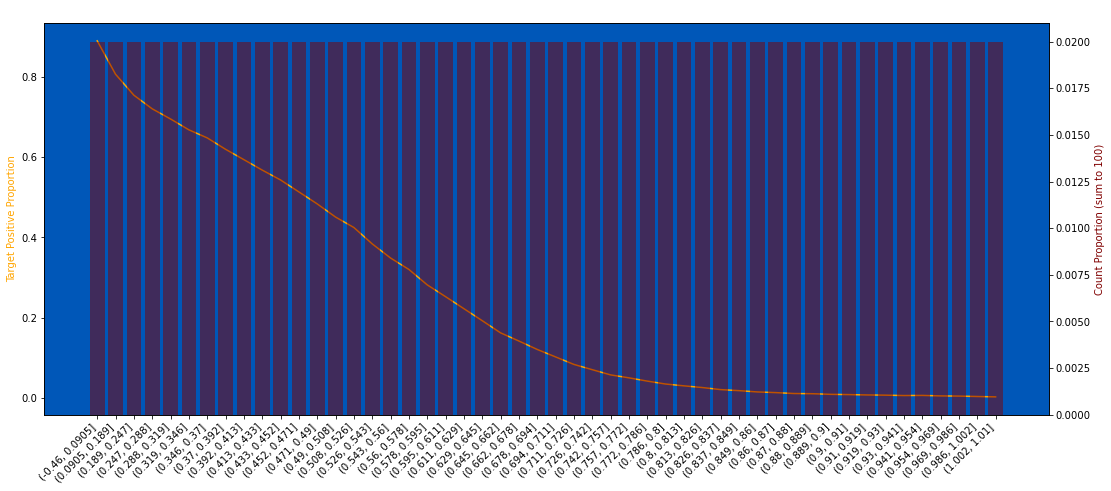

In [18]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True)

In [19]:
%%time
df_list = round_dfs(df_list, col="P_2", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 270 ms, sys: 957 ms, total: 1.23 s
Wall time: 2.23 s


45985 null count, 0.008 null proportion
0.2561 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


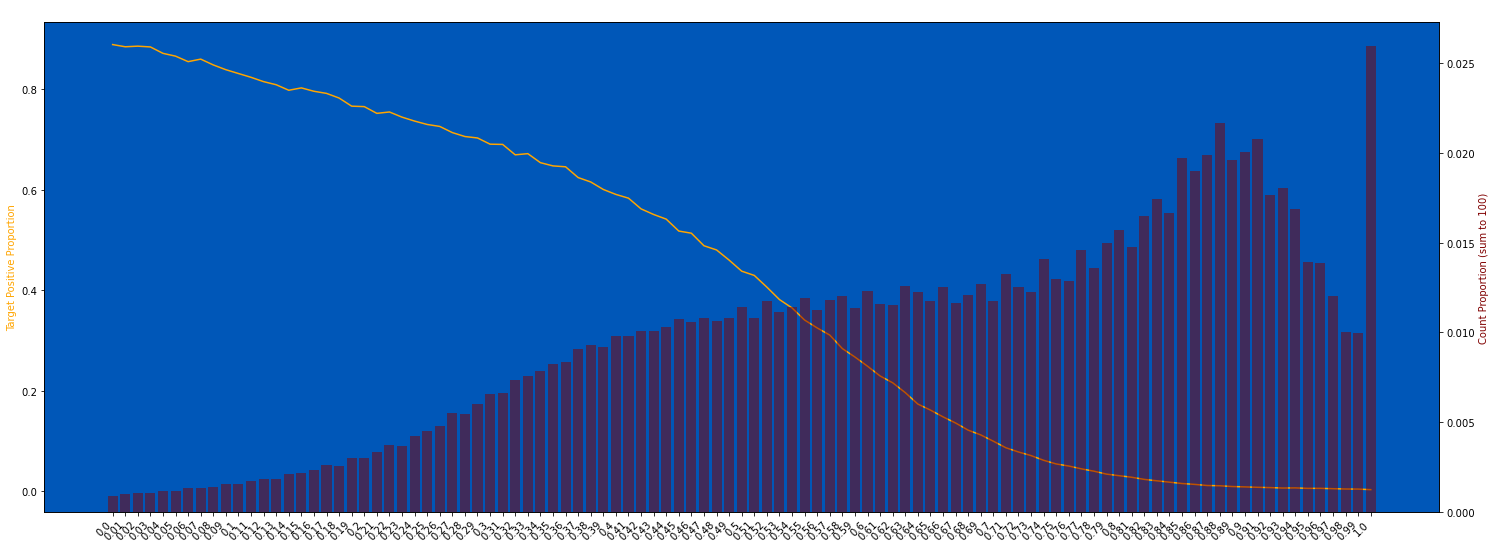

In [20]:
plot_target_check(train, "P_2", q=50, use_raw_bin=True, nunique_thr=150, strfy_x=True, figsize=(25, 10))

Bottom 1% and Top 1% are dropped from this chart


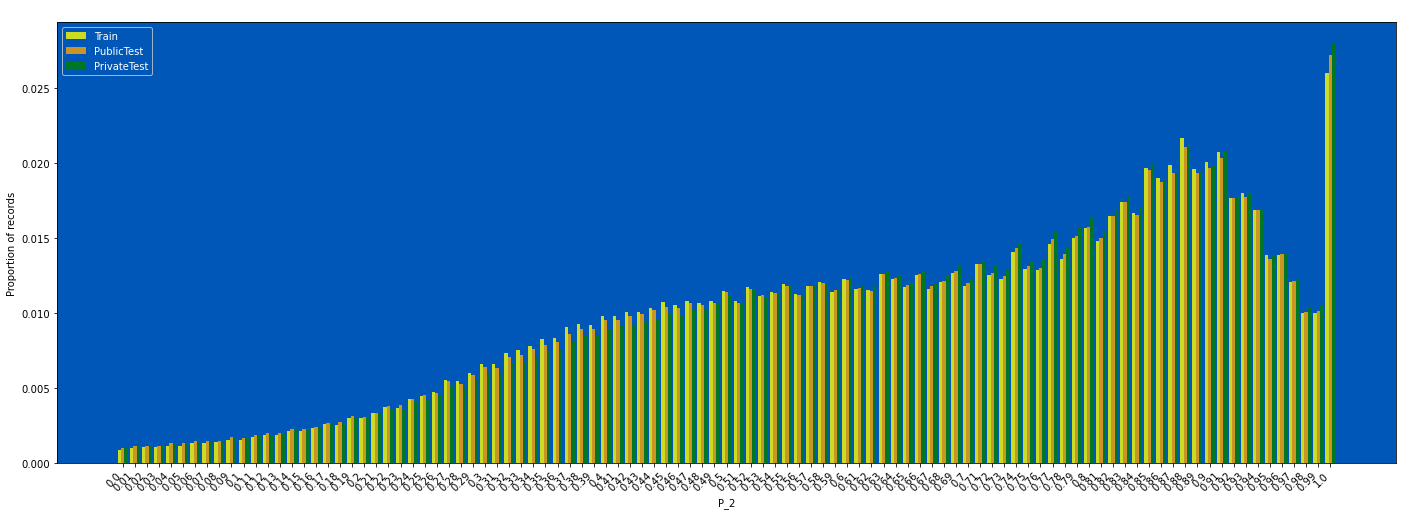

,P_2,Train,PublicTest,PrivateTest
47,0.0000,0.0009,0.0010,0.0010
48,0.0100,0.0010,0.0011,0.0012
49,0.0200,0.0010,0.0012,0.0011
50,0.0300,0.0011,0.0012,0.0012
51,0.0400,0.0012,0.0013,0.0013
...,...,...,...,...
143,0.9600,0.0139,0.0139,0.0140
144,0.9700,0.0120,0.0121,0.0123
145,0.9800,0.0100,0.0101,0.0104
146,0.9900,0.0100,0.0102,0.0105


In [98]:
plot_train_test_distribution(df_list, "P_2", nunique_thr=150, figsize=(24, 9))

**Train Test Skew: Moderate**

In [20]:
# from scipy.stats import ks_2samp
# import numpy as np
# ks_2samp(train["P_2"].dropna(), test["P_2"].dropna())

In [21]:
# plot_sampled_time_series(train, labels, "P_2", 50)

### P_3

301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1


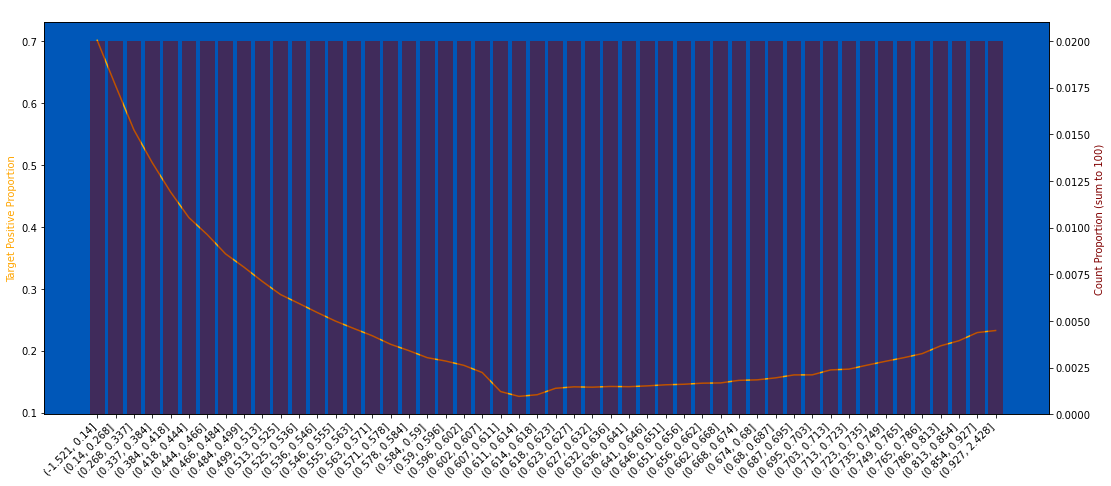

In [22]:
plot_target_check(train, "P_3", q=50, use_raw_bin=True)

In [23]:
%%time
df_list = round_dfs(df_list, col="P_3", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 249 ms, sys: 767 ms, total: 1.02 s
Wall time: 1.95 s


301492 null count, 0.055 null proportion
0.4439 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


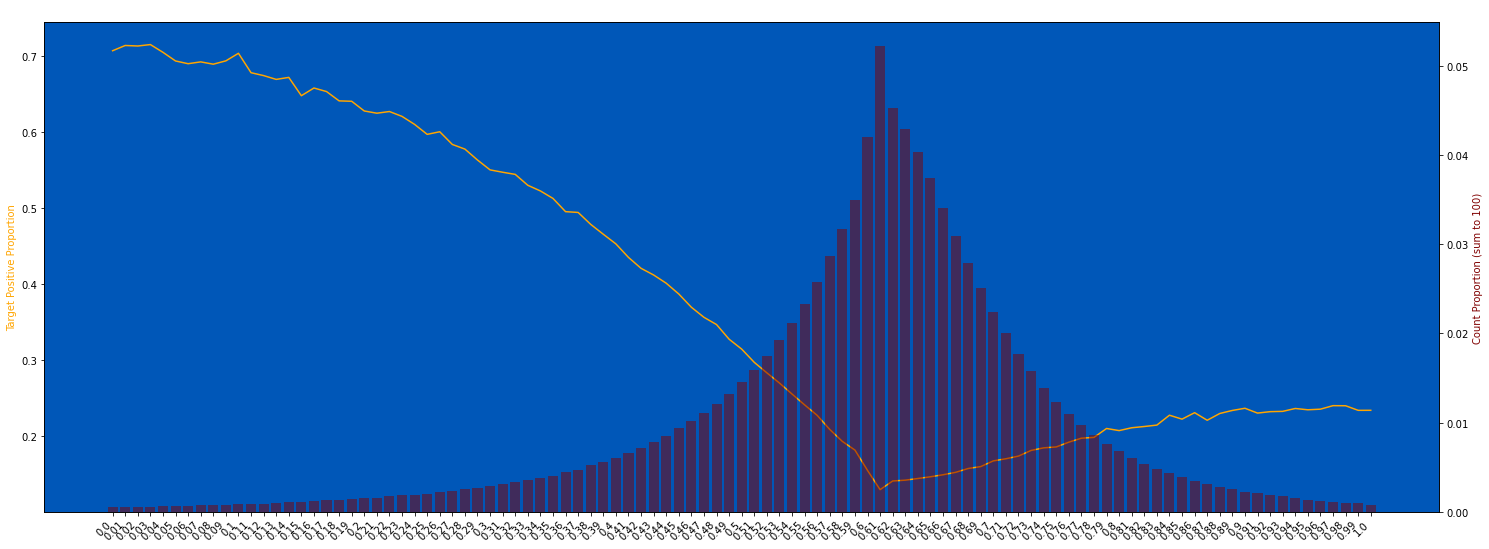

In [24]:
p3_summary = plot_target_check(train, "P_3", q=50, use_raw_bin=True, nunique_thr=340, strfy_x=True, figsize=(25, 10), 
                               drop_outlier=True, return_df=True)

**ToDo:**
- Try come out with a feature with monotone relationship and see

Bottom 1% and Top 1% are dropped from this chart


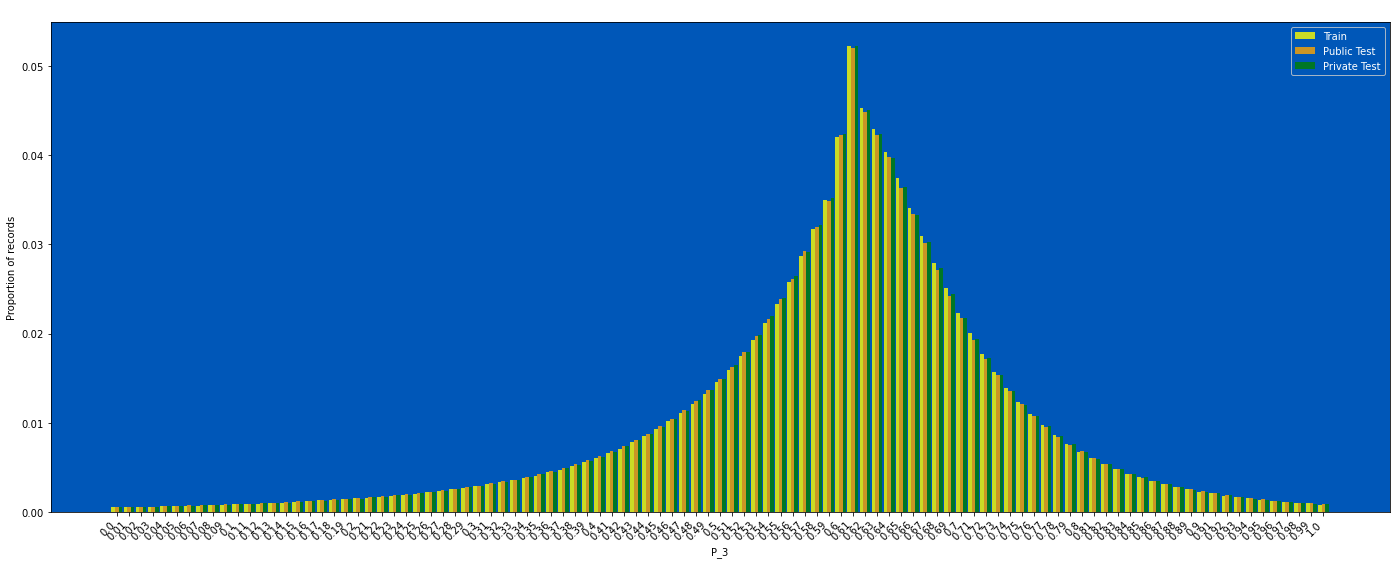

In [25]:
plot_train_test_distribution(df_list, "P_3", nunique_thr=340, figsize=(24, 10))
# plot_train_test_distribution(train, private_test, "P_3", nunique_thr=340, figsize=(24, 10))

### P_4

0 null count, 0.000 null proportion
nan of the targets have label = 1


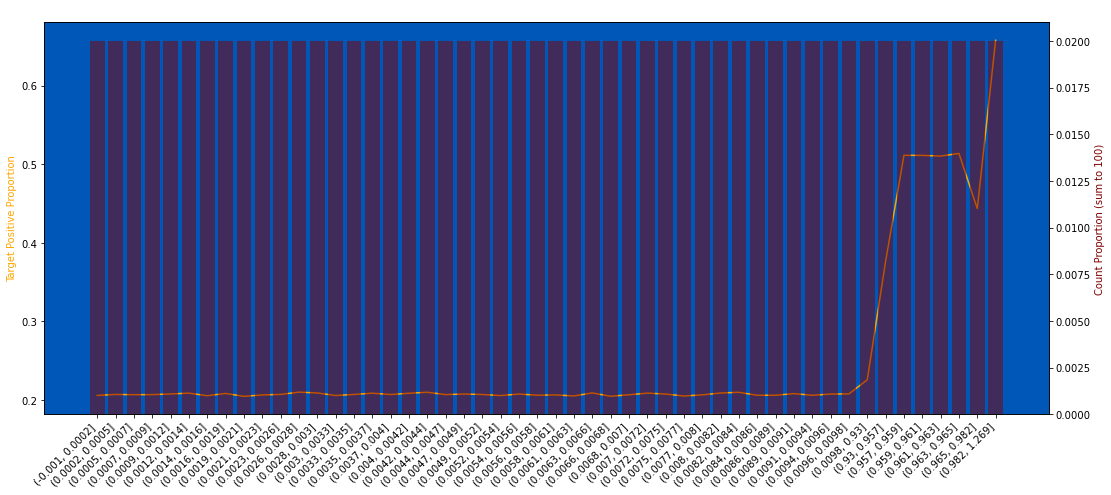

In [26]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True)

In [27]:
%%time
df_list = round_dfs(df_list, col="P_4", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 247 ms, sys: 809 ms, total: 1.06 s
Wall time: 1.94 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


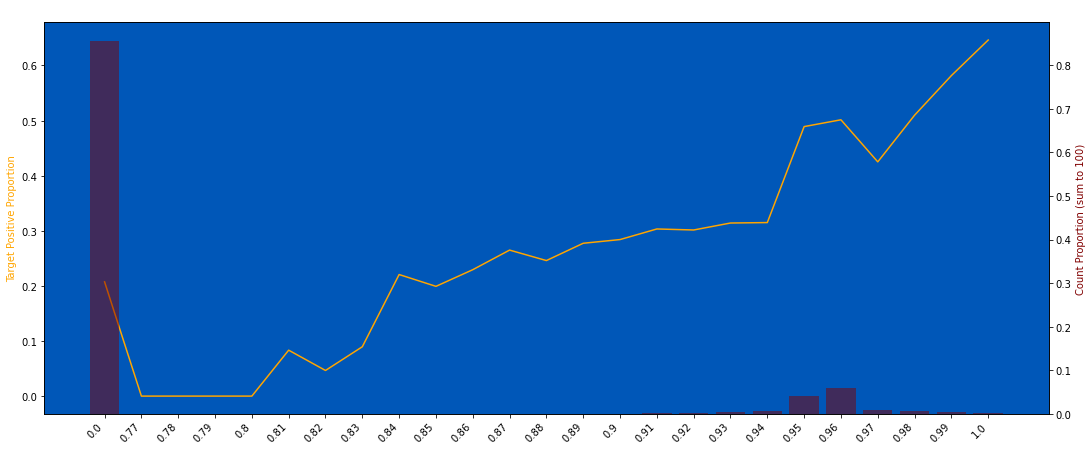

In [28]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

**Comments:**
- P_4 in (0, 0.01) should be NaN, because it has different default trend + extremely low values (outlier)
- Also, original P_4 has no missing values

In [29]:
%%time
df_list = fill_nans(df_list, col="P_4", tuple_of_values=(0, 0.01), add_new_col=False)

CPU times: user 341 ms, sys: 1.21 s, total: 1.55 s
Wall time: 326 ms


4732506 null count, 0.856 null proportion
0.2073 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


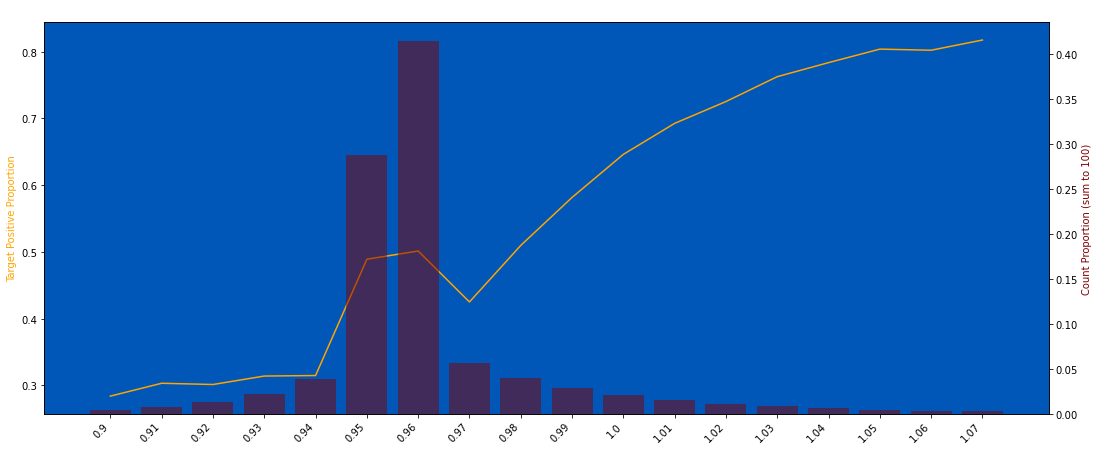

In [30]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

In [31]:
for df in df_list:
    df["P_4_"] = df["P_4"].copy()
    df.loc[df["P_4"].between(0.95, 0.96), "P_4_"] = np.nan

In [32]:
for col in train.columns[2:]:
    if col == "temp":
        continue
    corrcoef = train[["P_4_", col]].dropna().corr().iloc[0, 1]
    if abs(corrcoef) >= 0.3:
        print(col, corrcoef)

P_2 -0.6002508440954489
P_3 -0.8577565687089909
P_4 1.0
target 0.32870382490887357
P_4_ 1.0


In [33]:
train["P_2"].describe()

count   5,485,466.0000
mean            0.6513
std             0.2447
min            -0.4600
25%             0.4800
50%             0.6900
75%             0.8600
max             1.0000
Name: P_2, dtype: float64

In [34]:
train.loc[train["P_2"].isnull(), "P_4"].describe()

count   19,954.0000
mean         0.9560
std          0.0049
min          0.9500
25%          0.9500
50%          0.9600
75%          0.9600
max          0.9600
Name: P_4, dtype: float64

In [35]:
np.percentile(train.loc[train["P_2"].isnull(), "P_4"].dropna(), 0)

0.95

In [36]:
np.percentile(train.loc[train["P_2"].isnull(), "P_4"].dropna(), 100)

0.96

**Comments:**
- When P_2 is null, P_4 is always 0.95 - 0.96
- Replace those P_4 (0.95 - 0.96) with NaN

In [37]:
for df in df_list:
    df.loc[(df["P_4"].between(0.95, 0.96)) & (df["P_2"].isnull()), "P_4"] = np.nan

4752460 null count, 0.859 null proportion
0.2083 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


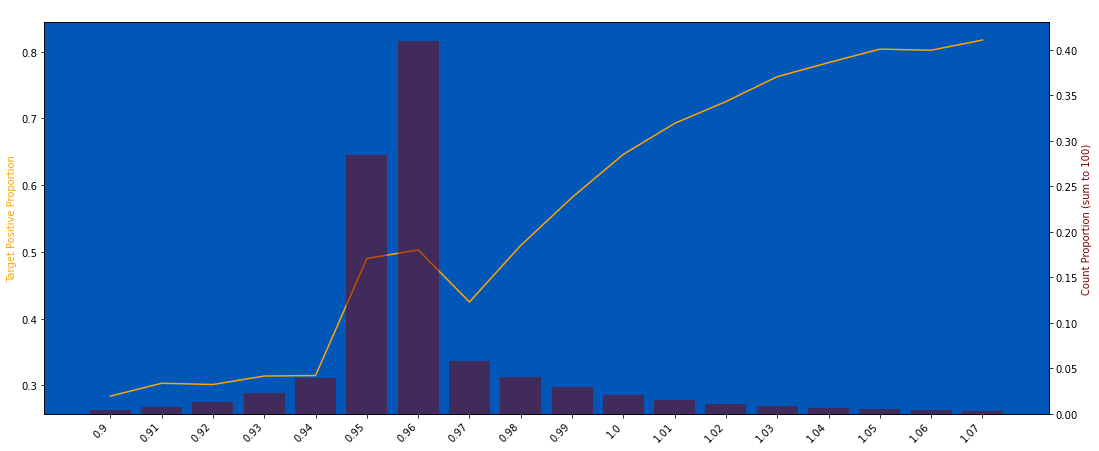

In [38]:
plot_target_check(train, "P_4", q=50, use_raw_bin=True, strfy_x=True)

**ToDo:**
- Identify the subset of P_4 in (0.95, 0.96) to fill with other values, to fix
  - The spike in default trend & distribution bell curve

Bottom 1% and Top 1% are dropped from this chart


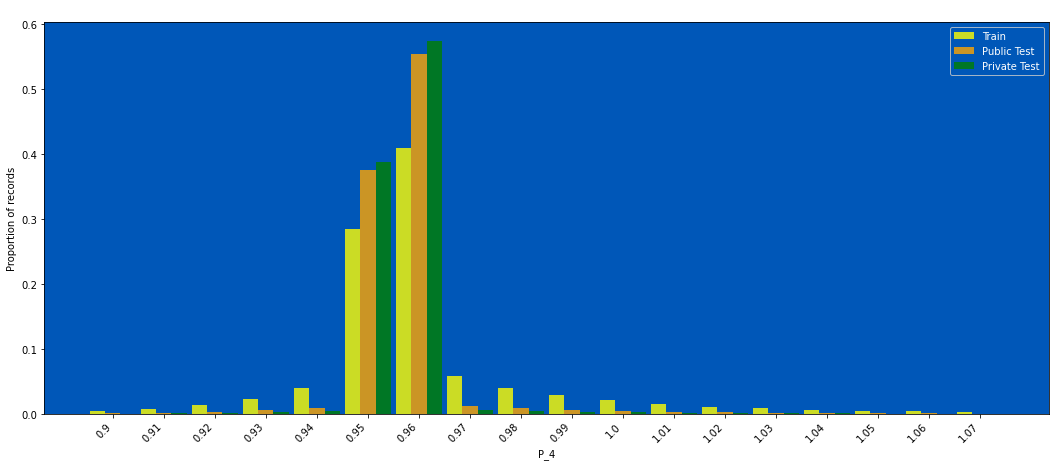

In [39]:
plot_train_test_distribution(df_list, "P_4")

**Train Test Skew: Heavy**

### S_3

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


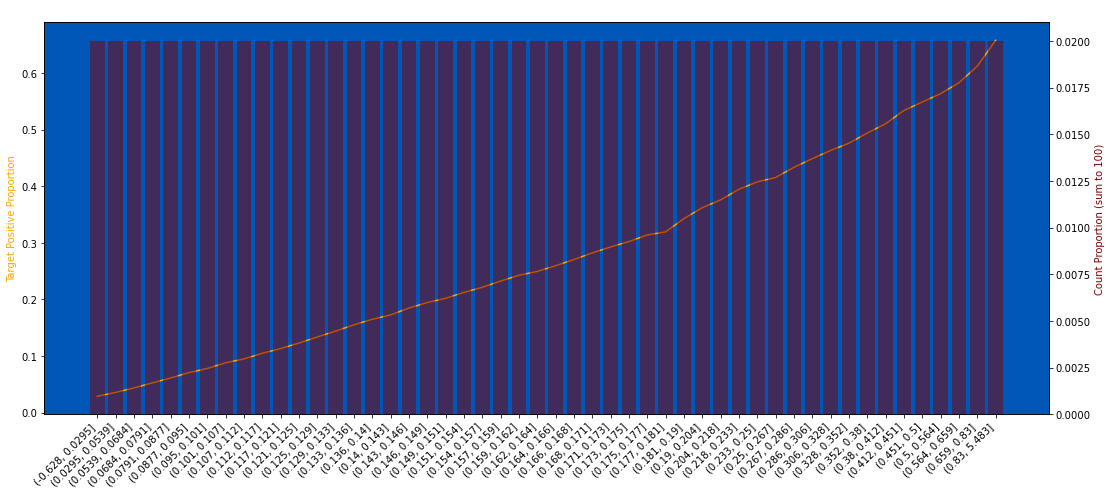

In [40]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True)

In [41]:
%%time
df_list = round_dfs(df_list, col="S_3", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 269 ms, sys: 809 ms, total: 1.08 s
Wall time: 2.03 s


1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


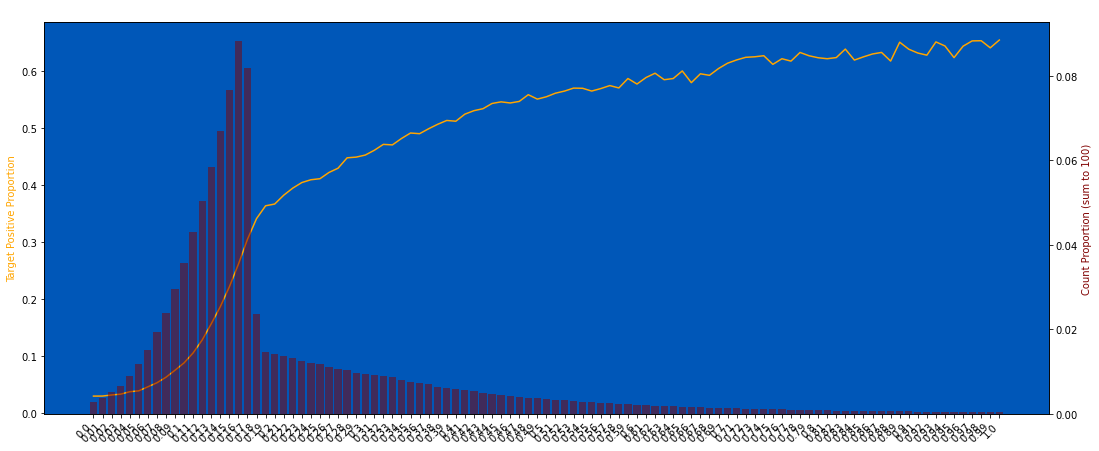

In [42]:
plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True)

**ToDo:**
- Apply manual stacking / binning on right tail

In [43]:
# for df in df_list:
#     df["S_3"] = df["S_3"].parallel_apply(lambda x: manual_stack(x, start=0.18, stack_interval=0.04, denom=100))

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


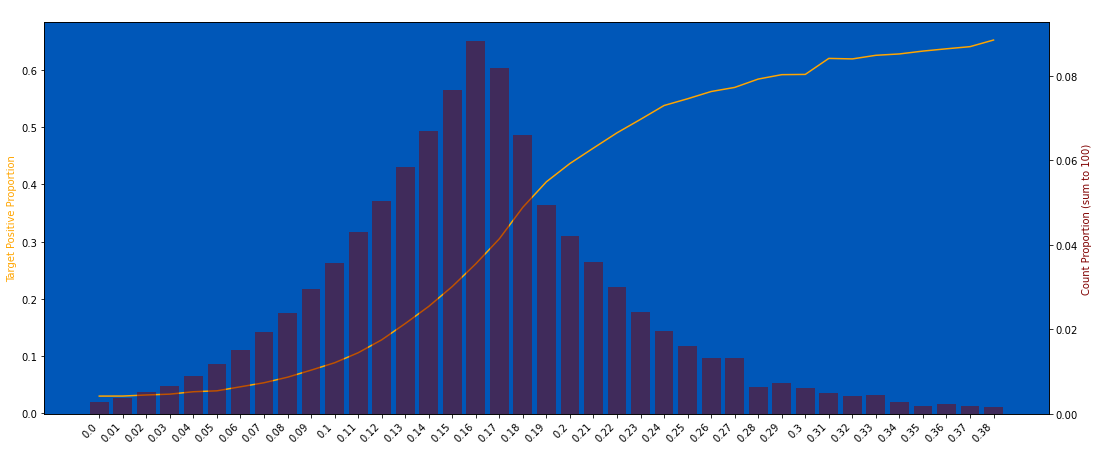

In [44]:
# plot_target_check(train, "S_3", q=50, use_raw_bin=True, nunique_thr=700, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


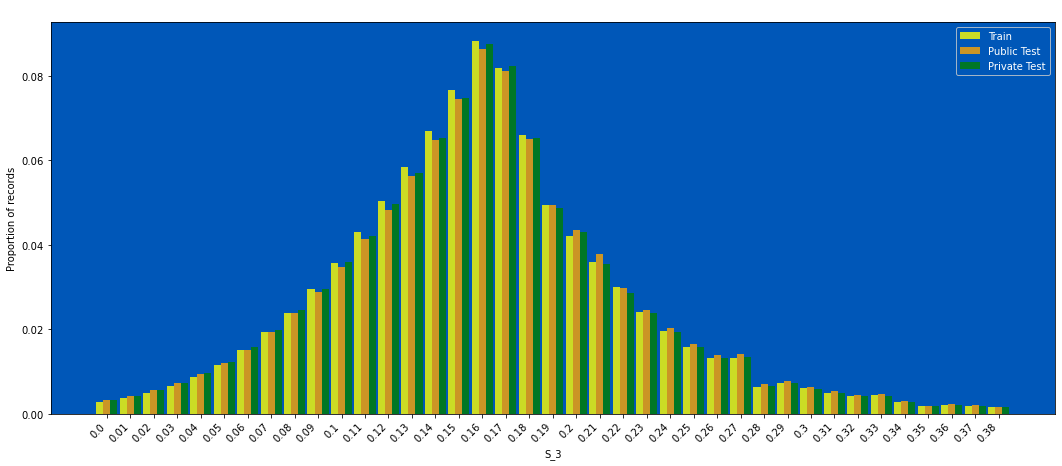

In [45]:
plot_train_test_distribution(df_list, "S_3", nunique_thr=500)

### S_5

0 null count, 0.000 null proportion
nan of the targets have label = 1


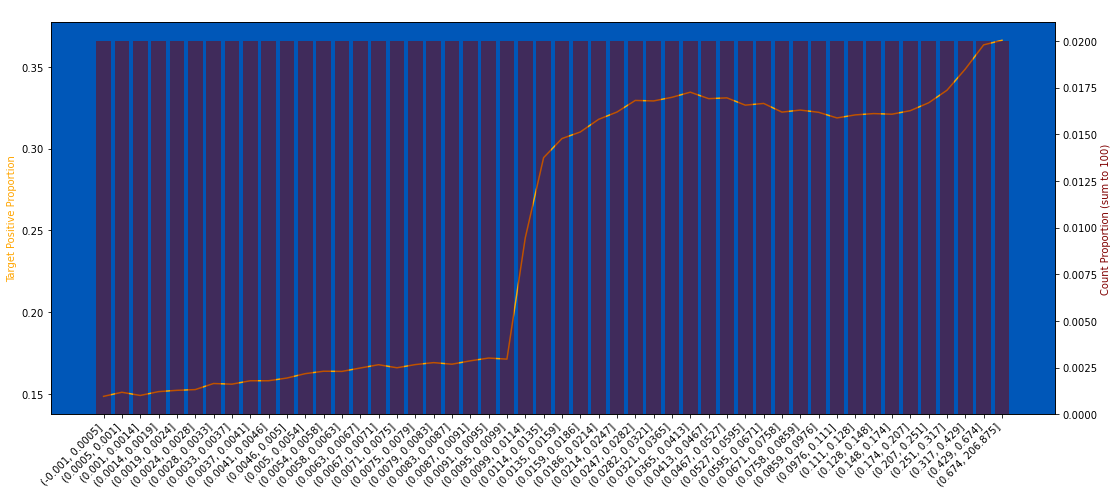

In [46]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True)

In [47]:
%%time
df_list = round_dfs(df_list, col="S_5", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 261 ms, sys: 857 ms, total: 1.12 s
Wall time: 2.06 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


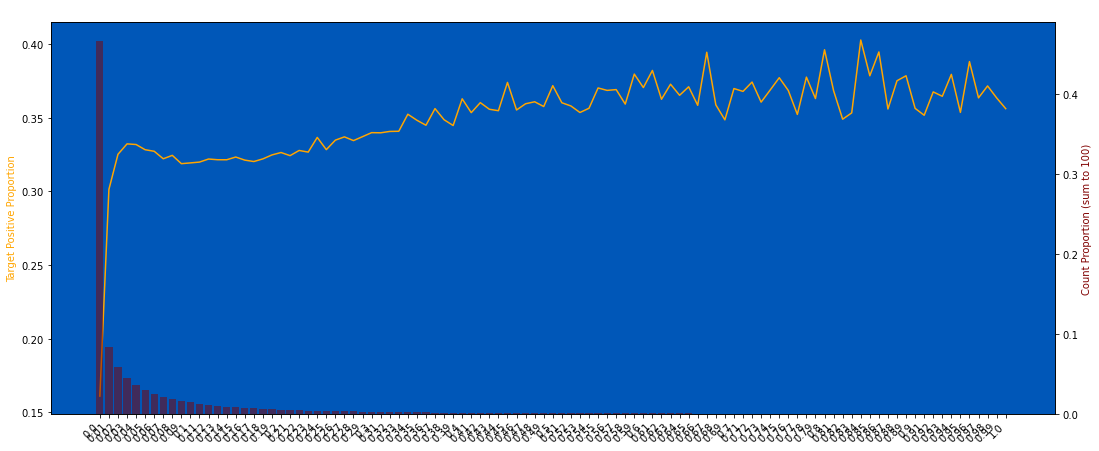

In [48]:
plot_target_check(train, "S_5", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

**ToDo:**
- Should apply manual stack / binning on the right tail

Bottom 1% and Top 1% are dropped from this chart


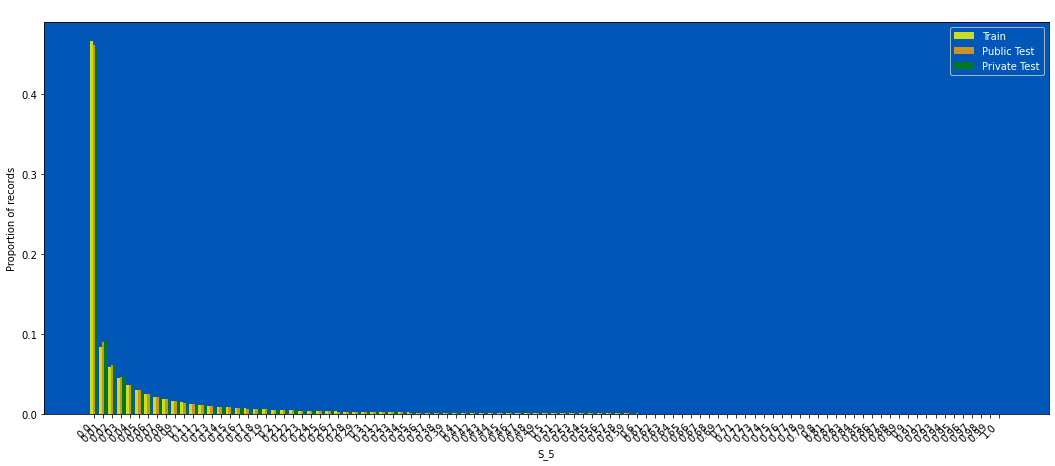

In [49]:
plot_train_test_distribution(df_list, "S_5", nunique_thr=5000)

### S_6 (Done)

0 null count, 0.000 null proportion
nan of the targets have label = 1


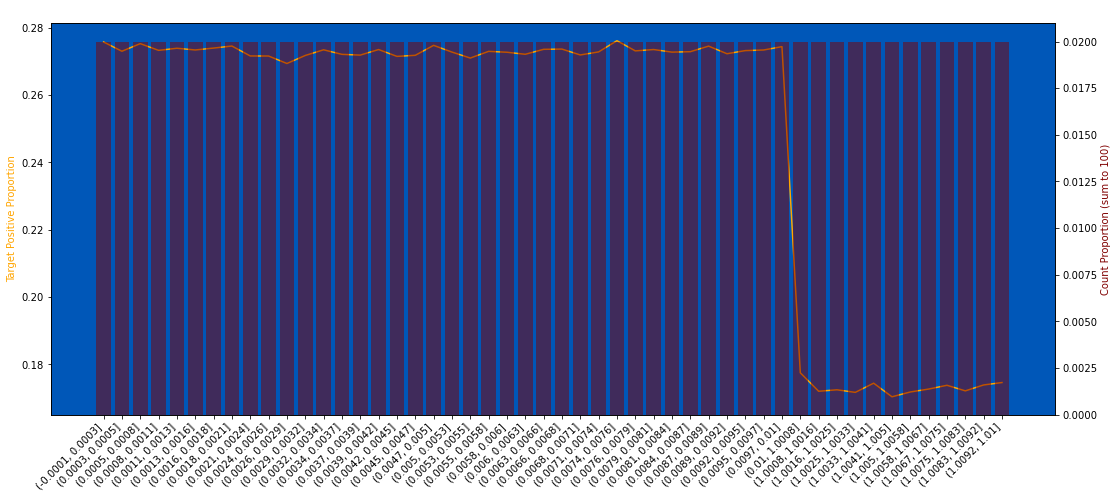

In [50]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True)

In [51]:
%%time
df_list = round_dfs(df_list, col="S_6", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 258 ms, sys: 979 ms, total: 1.24 s
Wall time: 2.15 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


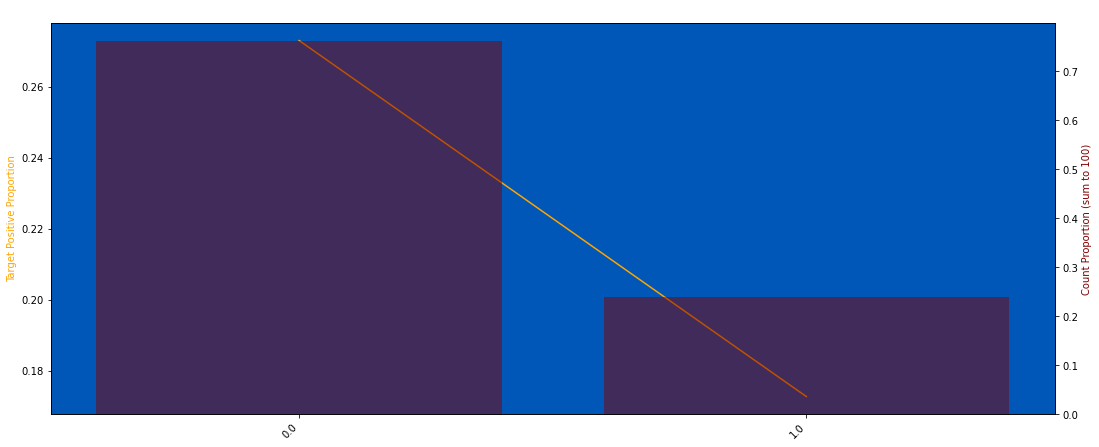

In [52]:
plot_target_check(train, "S_6", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [53]:
for df in df_list:
    df["S_6"] = integerize(df["S_6"])

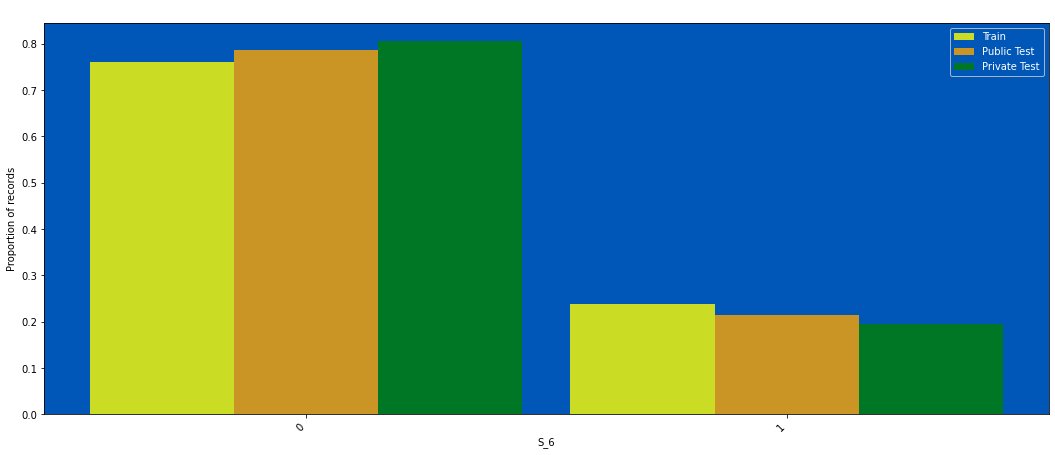

In [54]:
plot_train_test_distribution(df_list, "S_6", nunique_thr=50)

### S_7

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1


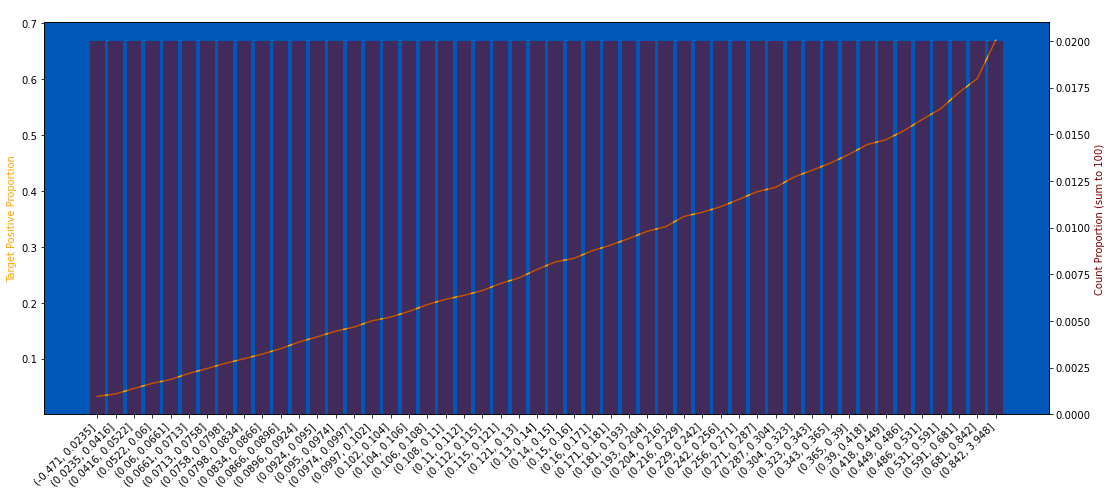

In [55]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True)

In [56]:
%%time
df_list = round_dfs(df_list, col="S_7", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 225 ms, sys: 982 ms, total: 1.21 s
Wall time: 2.19 s


1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


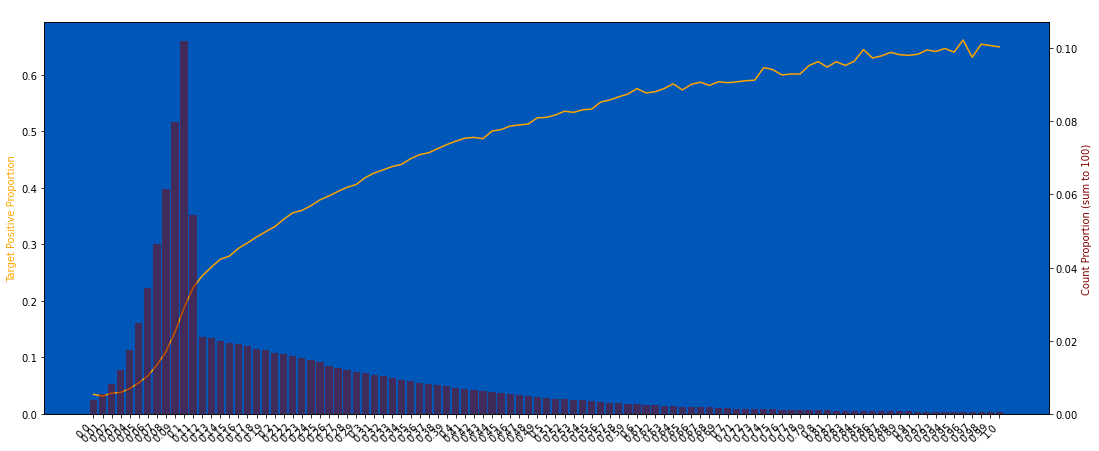

In [57]:
plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

**ToDo:**
- Apply manual stacking / binning on right tail

In [58]:
# for df in df_list:
#     df["S_7"] = df["S_7"].parallel_apply(lambda x: manual_stack(x, start=0.11, stack_interval=0.06, denom=100))

1020544 null count, 0.184 null proportion
0.1064 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


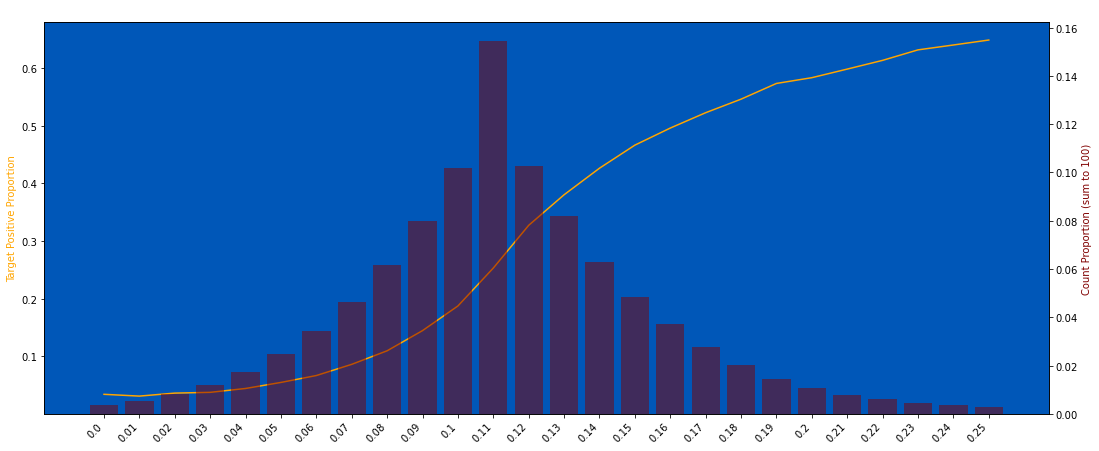

In [59]:
# plot_target_check(train, "S_7", q=50, use_raw_bin=True, nunique_thr=360, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


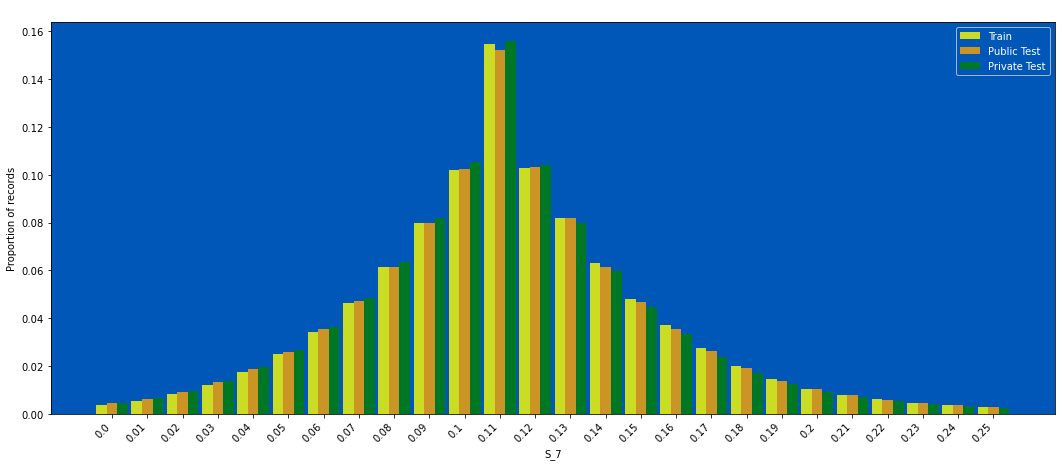

In [60]:
plot_train_test_distribution(df_list, "S_7", nunique_thr=5000)

### S_8

0 null count, 0.000 null proportion
nan of the targets have label = 1


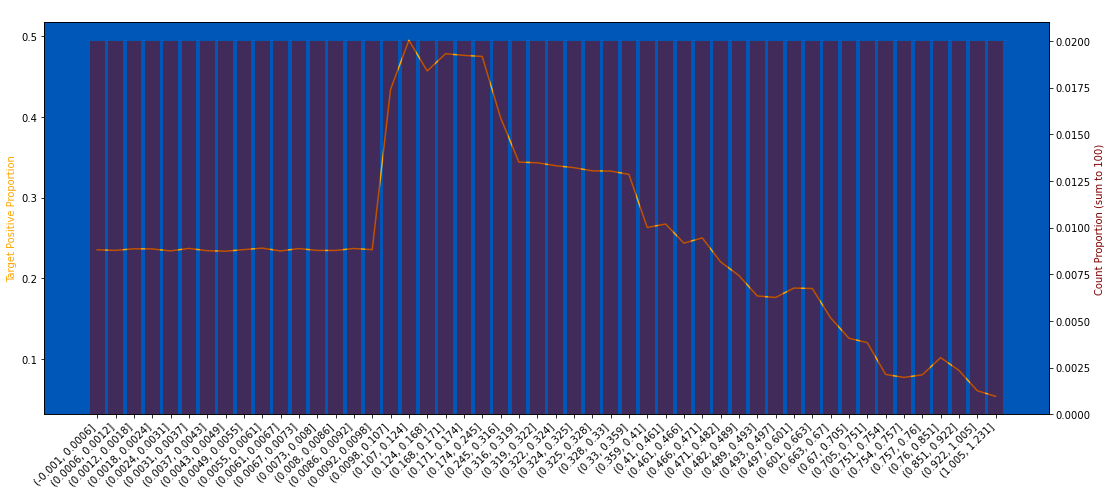

In [61]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

In [62]:
%%time
df_list = round_dfs(df_list, col="S_8", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 241 ms, sys: 970 ms, total: 1.21 s
Wall time: 2.14 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


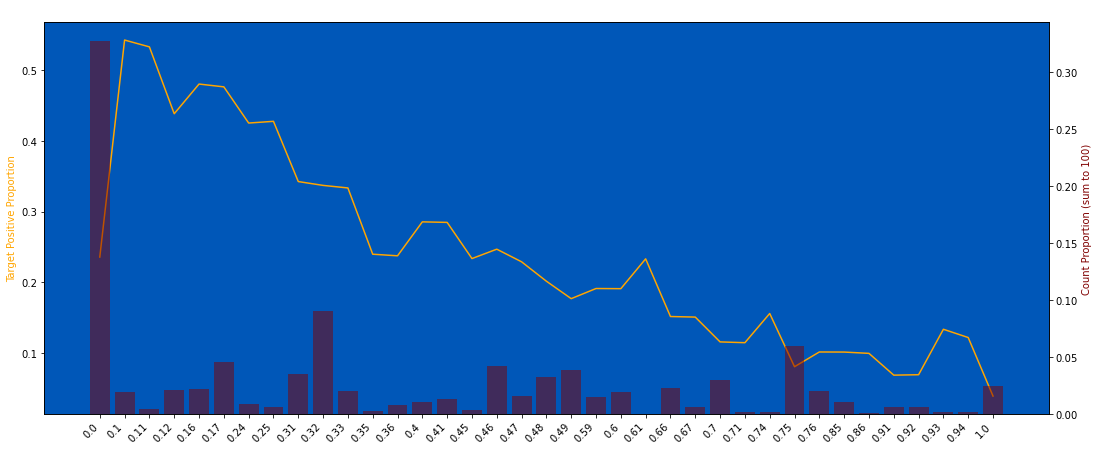

In [63]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

**Comments**
- S_8 in (0, 0.01) is likely to be NaN, because it violates the default rate downward trend & its average default rate is around 25%
- Also, original S_8 has no null values

In [64]:
%%time
df_list = fill_nans(df_list, col="S_8", tuple_of_values=(0, 0.01), add_new_col=False)

CPU times: user 429 ms, sys: 686 ms, total: 1.12 s
Wall time: 316 ms


1808480 null count, 0.327 null proportion
0.2354 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


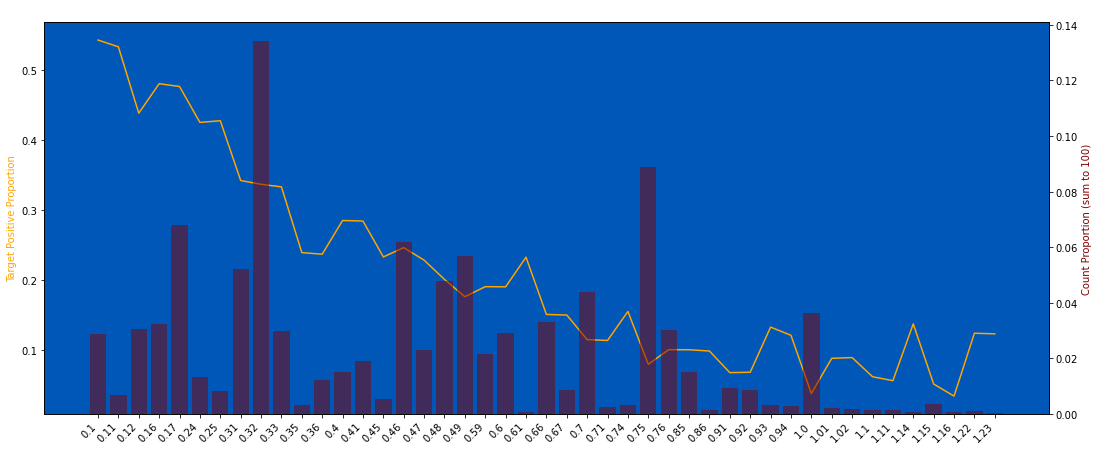

In [65]:
plot_target_check(train, "S_8", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


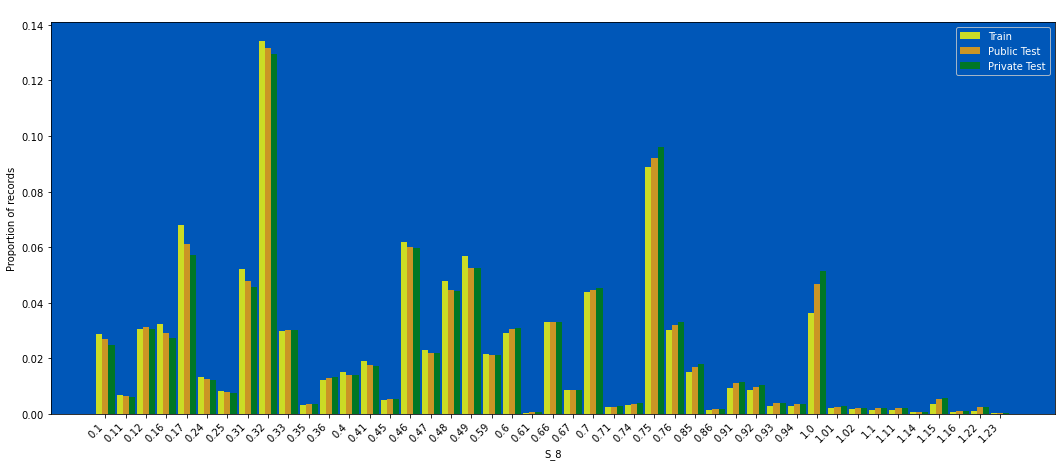

In [66]:
plot_train_test_distribution(df_list, "S_8", nunique_thr=500, without_drop_tail=True)

### S_9

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1


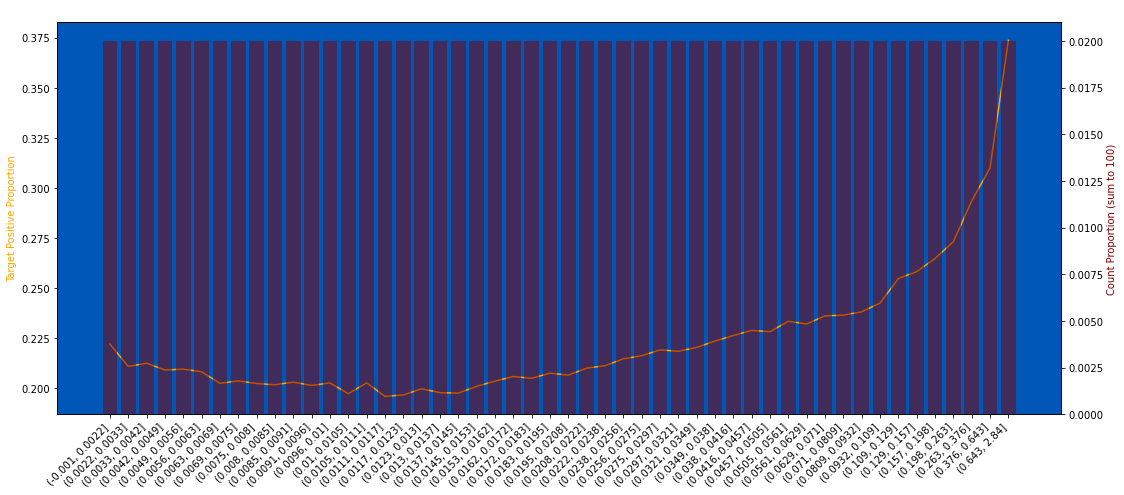

In [67]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True)

In [68]:
%%time
df_list = round_dfs(df_list, col="S_9", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 244 ms, sys: 934 ms, total: 1.18 s
Wall time: 2.19 s


2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


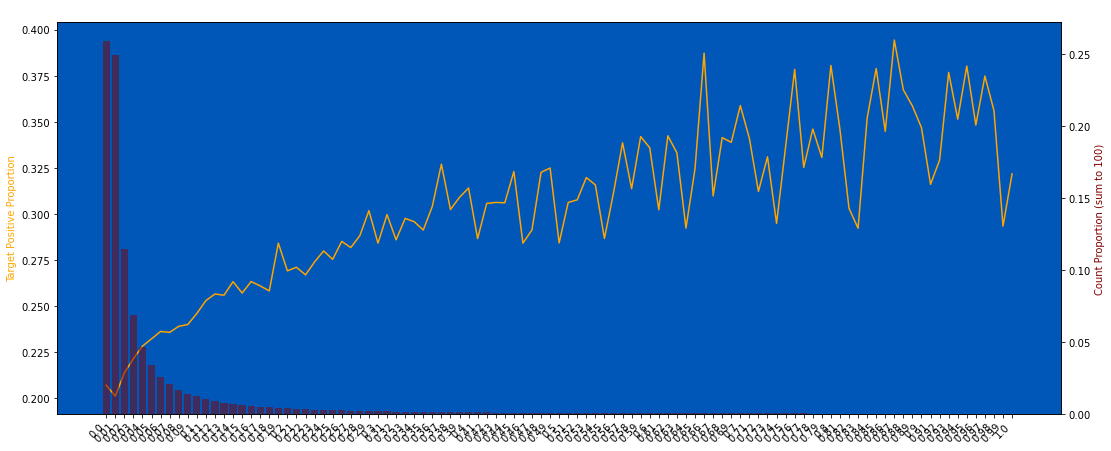

In [69]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True, nunique_thr=300, strfy_x=True)

In [70]:
for df in df_list:
    df["S_9"] = df["S_9"].parallel_apply(lambda x: manual_stack(x, start=0, stack_interval=0.04, denom=100))

2933643 null count, 0.530 null proportion
0.2719 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


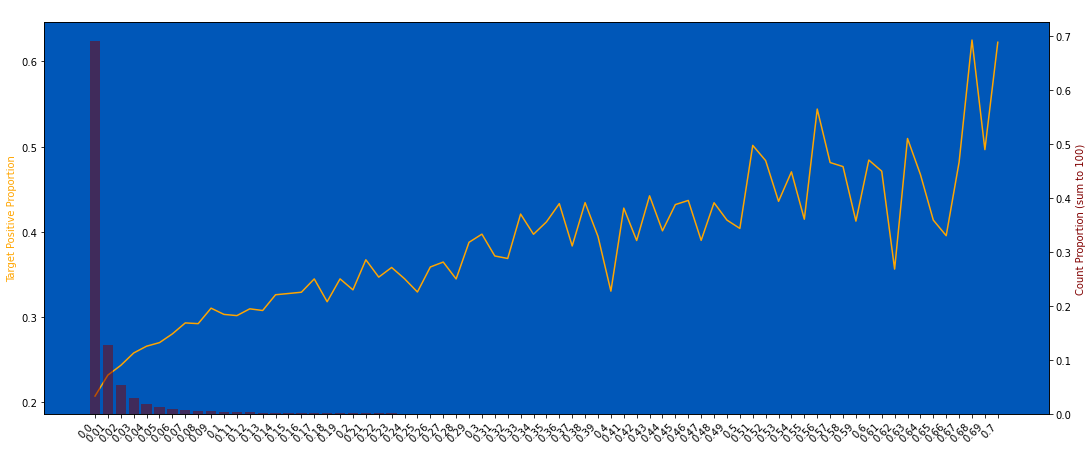

In [71]:
plot_target_check(train, "S_9", q=50, use_raw_bin=True, nunique_thr=300, strfy_x=True, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


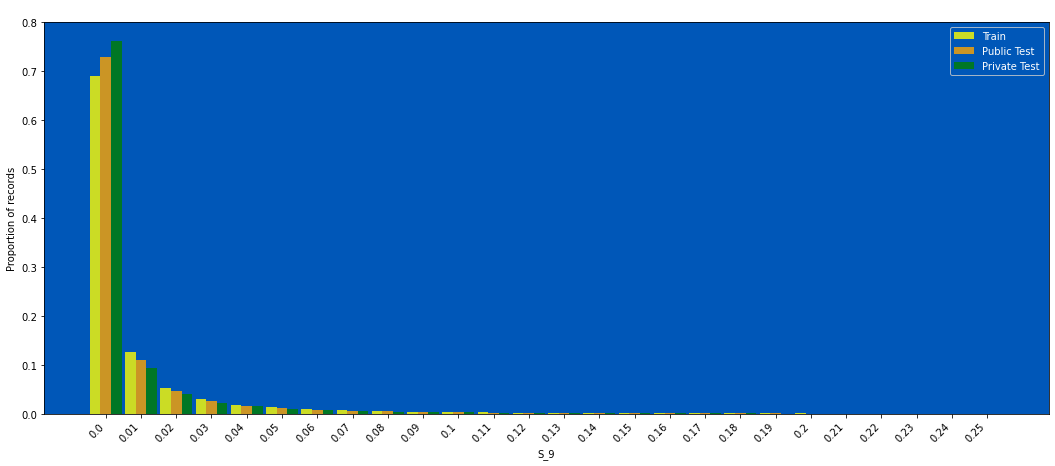

In [72]:
plot_train_test_distribution(df_list, "S_9", nunique_thr=300)

**Train Test Skew: Moderate**

### S_11

0 null count, 0.000 null proportion
nan of the targets have label = 1


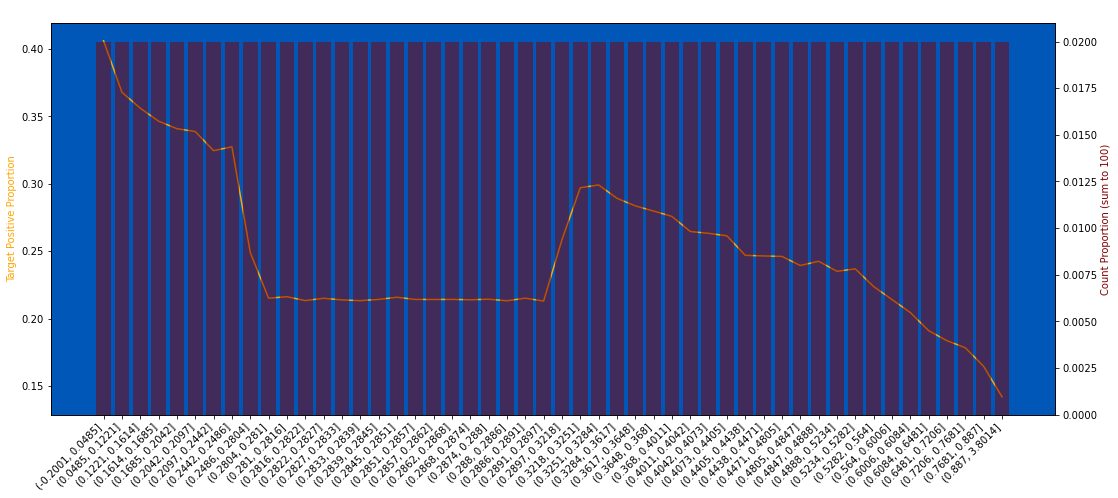

In [73]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True)

In [74]:
df_list = round_dfs(df_list, col="S_11", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


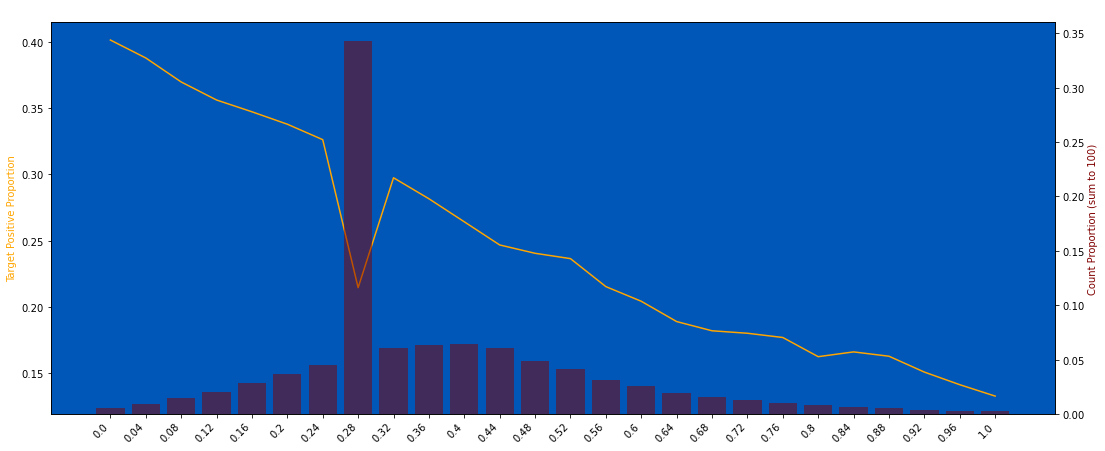

In [75]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [76]:
for df in df_list:
    df["S_11"] = df["S_11"] / 0.04

In [77]:
df_list = round_dfs(df_list, col="S_11", decimals=0, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


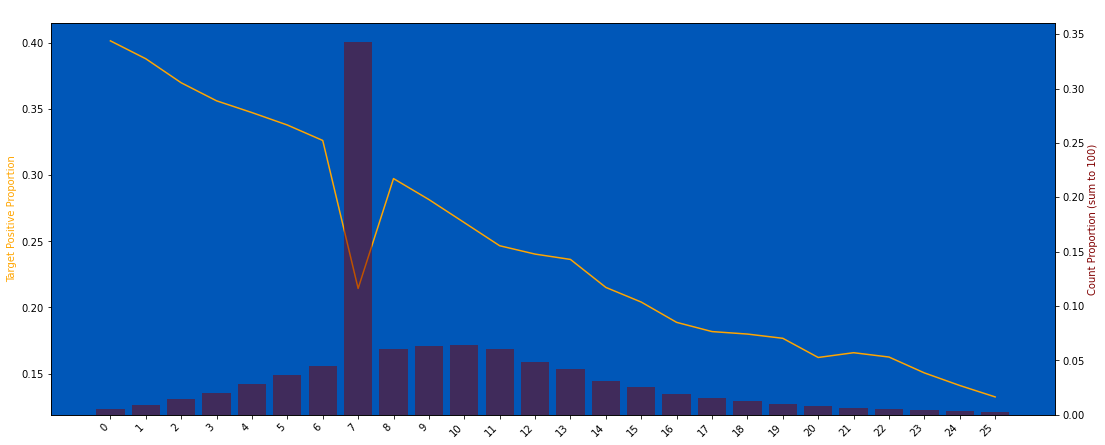

In [78]:
plot_target_check(train, "S_11", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [79]:
for df in df_list:
    df["S_11_"] = df["S_11"].copy()
    df.loc[df["S_11"] == 7, "S_11_"] = np.nan

In [80]:
for col in train.columns[2:]:
    if col == "temp":
        continue
    corrcoef = train[["S_11_", col]].dropna().corr().iloc[0, 1]
    if abs(corrcoef) >= 0.3:
        print(col, corrcoef)

S_11 1.0
S_13 0.3961294217870311
S_11_ 1.0


Bottom 1% and Top 1% are dropped from this chart


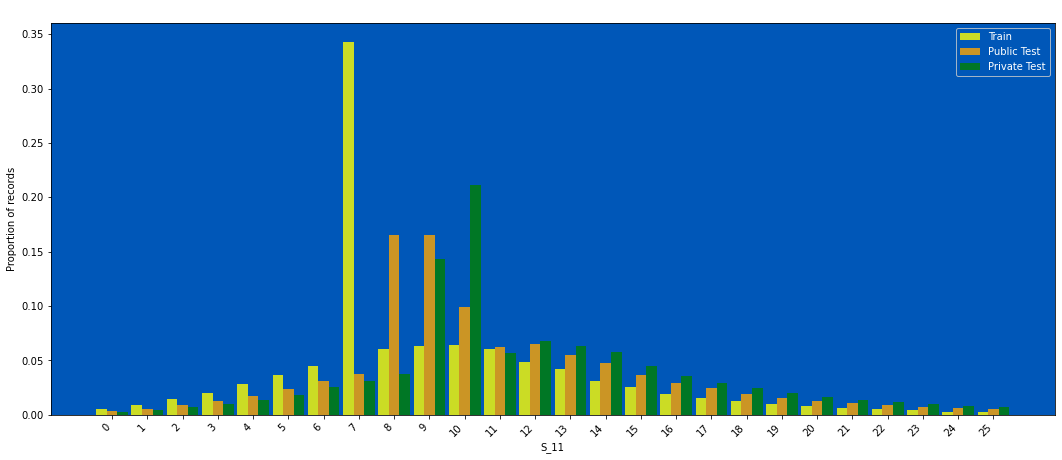

In [81]:
plot_train_test_distribution(df_list, "S_11", nunique_thr=50000)

**Train Test Skew: Heavy**

**ToDo:**
- Identify subset of 7 - 10 to be replace by other values to fix the train test skew & make the bell curve smoother
- If not able to do that, drop this column S_11

### S_12

0 null count, 0.000 null proportion
nan of the targets have label = 1


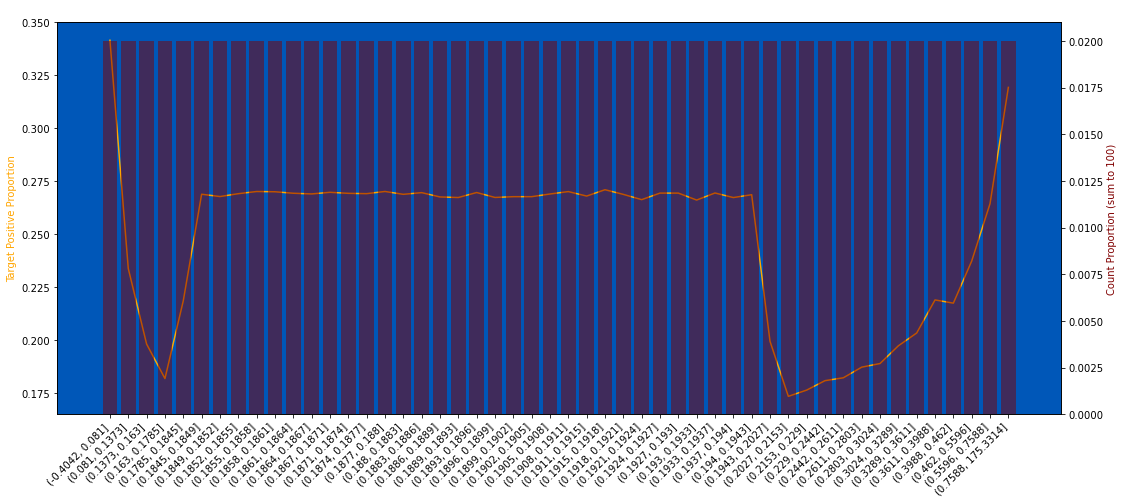

In [82]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True)

In [83]:
%%time
df_list = round_dfs(df_list, col="S_12", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 218 ms, sys: 984 ms, total: 1.2 s
Wall time: 2.13 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


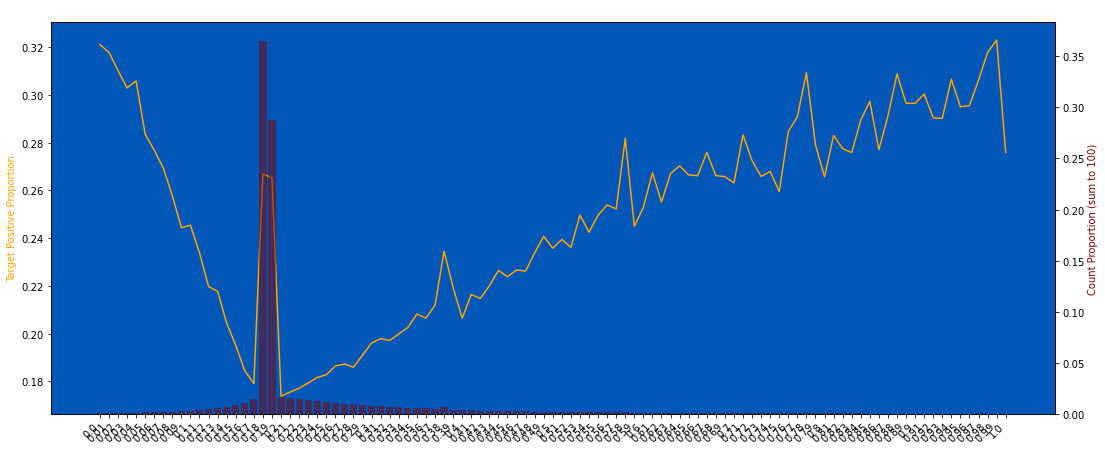

In [84]:
plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

#### ToDo:
- Replace some of the 0.18 & 0.19 with NaN, need to find the appropriate way to filter the subset to be replace

Bottom 1% and Top 1% are dropped from this chart


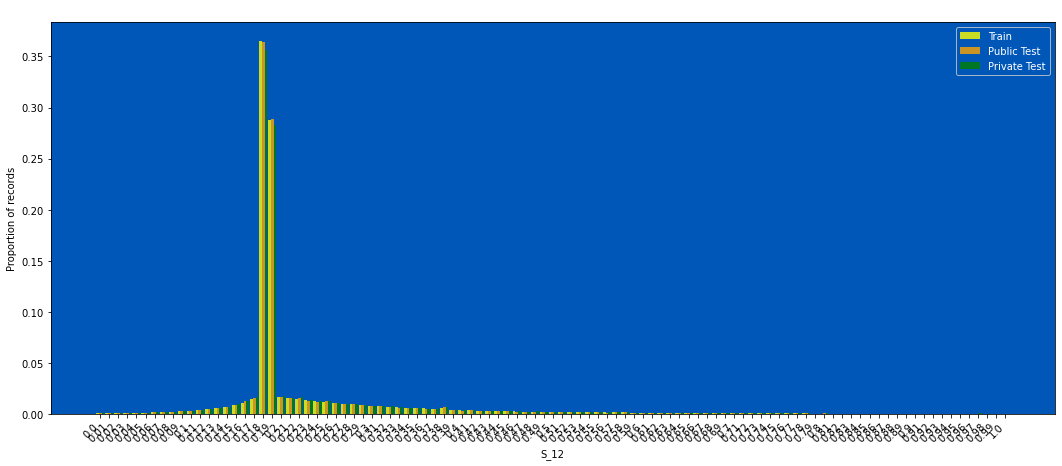

In [85]:
plot_train_test_distribution(df_list, "S_12", nunique_thr=50000)

**Train Test Skew: Mild**

In [86]:
# temp = train.loc[train["S_12"].between(0.18425, 0.19425)]
# plot_target_check(temp, "S_12", q=100, use_raw_bin=True, nunique_thr=2, strfy_x=True)

In [87]:
# train, test = fill_nans(train, test, col="S_12", method="range", range_of_values=(0.1842, 0.1943), add_new_col=False)

In [88]:
# %%time
# train, test = round_dfs(train, test, col="S_12", decimals=2, add_new_col=False)

In [89]:
# s12_summary = plot_target_check(train, "S_12", q=50, use_raw_bin=True, nunique_thr=10000, strfy_x=True, return_df=True)

### S_13

0 null count, 0.000 null proportion
nan of the targets have label = 1


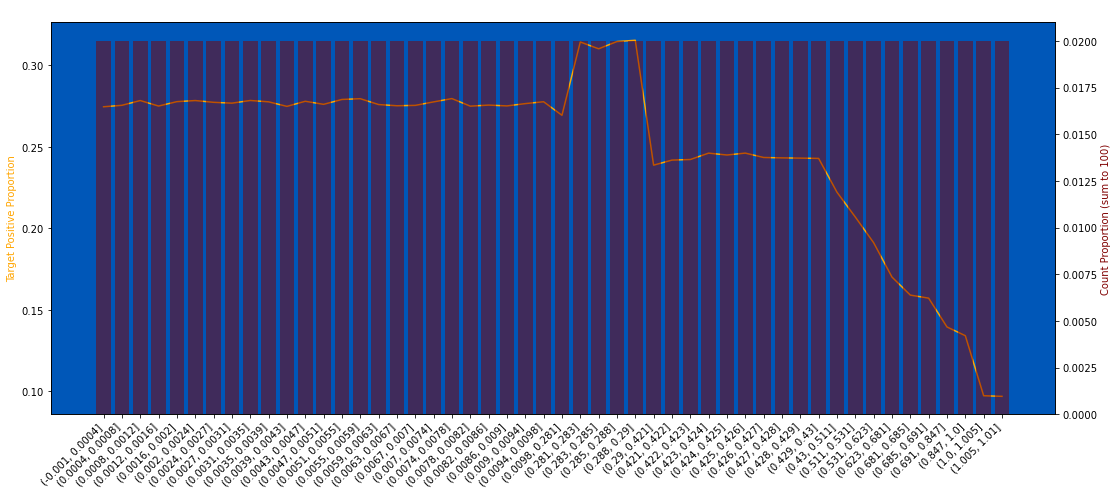

In [90]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=100, strfy_x=True)

In [91]:
%%time
df_list = round_dfs(df_list, col="S_13", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 258 ms, sys: 988 ms, total: 1.25 s
Wall time: 2.17 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


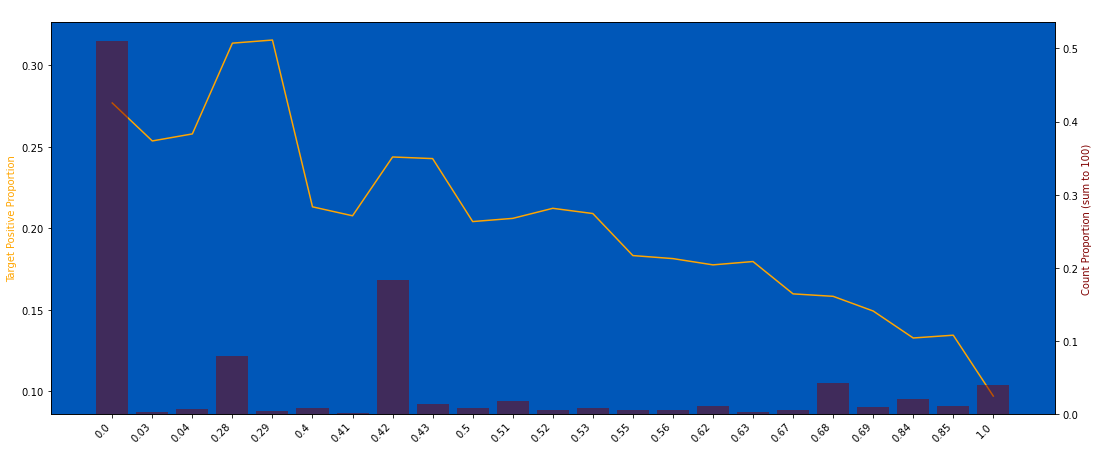

In [92]:
plot_target_check(train, "S_13", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

In [93]:
# for df in df_list:
#     df["S_13_"] = df["S_13"].parallel_apply(lambda x: manual_stack(x, start=0, stack_interval=0.07, denom=10))

In [94]:
# plot_target_check(train, "S_13_", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True, without_drop_tail=True)

Bottom 1% and Top 1% are dropped from this chart


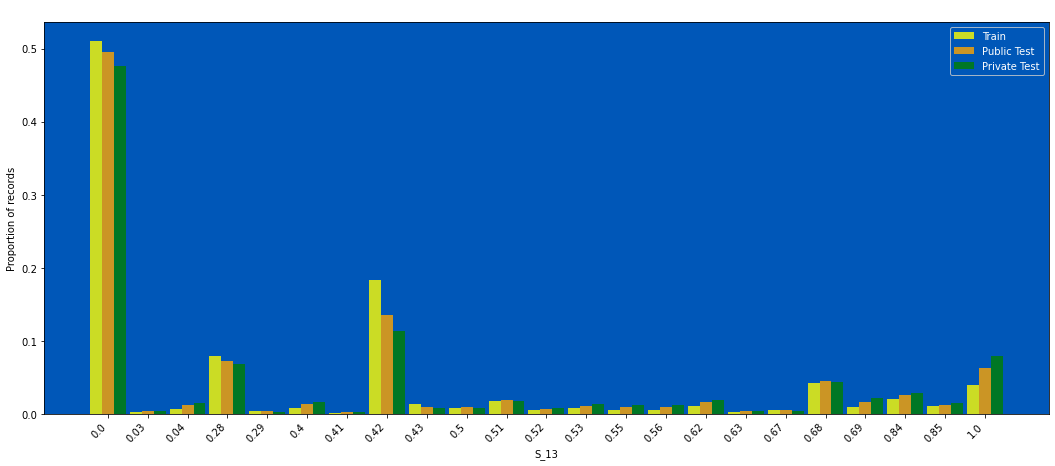

In [95]:
plot_train_test_distribution(df_list, "S_13", nunique_thr=50000)

### S_15

0 null count, 0.000 null proportion
nan of the targets have label = 1


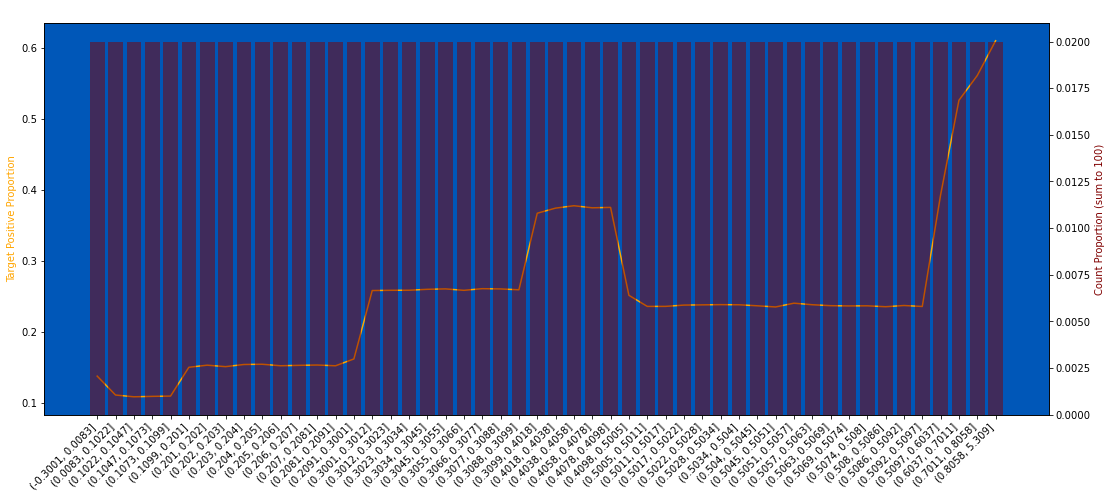

In [96]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True)

In [97]:
%%time
df_list = round_dfs(df_list, col="S_15", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 251 ms, sys: 1 s, total: 1.25 s
Wall time: 2.17 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


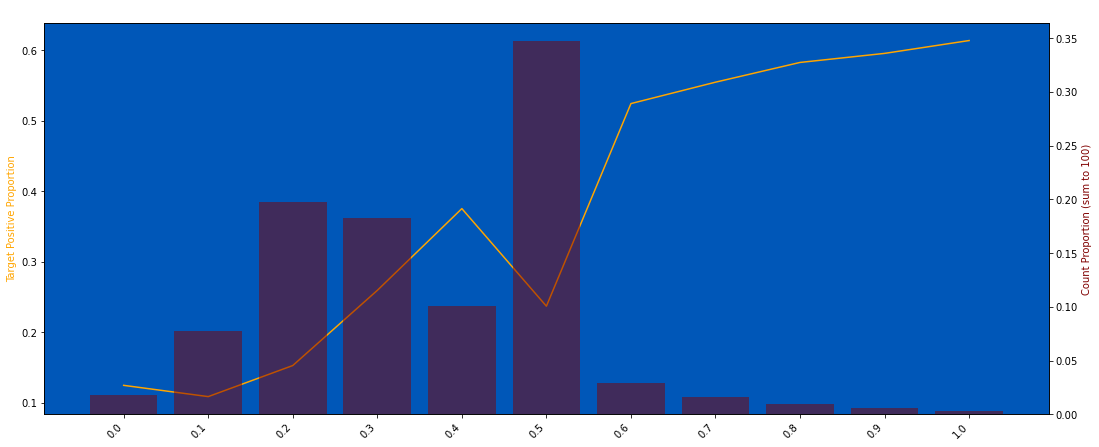

In [98]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

**Comments:**
- Some of the 0.5 - 0.51 are suspiciously null value, reason => violate bell curve & spike in default trend (lower default rate)

In [99]:
for df in df_list:
    df["S_15_"] = df["S_15"].copy()
    df.loc[df["S_15"].between(0.5, 0.51), "S_15_"] = np.nan

In [100]:
for col in train.columns[2:]:
    if col == "temp":
        continue
    corrcoef = train[["S_15_", col]].dropna().corr().iloc[0, 1]
    if abs(corrcoef) >= 0.3:
        print(col, corrcoef)

P_2 -0.3199988424449248
S_3 0.5347536850046375
S_7 0.4771684750463853
S_8 -0.7195495553333447
S_15 1.0
S_15_ 1.0


**Comments:**
- S_8 has the highest (absolute) correlation with S_15, use this information to cross validate the 0.5 - 0.51

In [101]:
train["S_8"].describe()

count   3,722,971.0000
mean            0.4793
std             0.2477
min             0.1000
25%             0.3200
50%             0.4600
75%             0.7000
max             1.2300
Name: S_8, dtype: float64

In [102]:
train.loc[train["S_8"].isnull(), "S_15"].describe()

count   1,808,480.0000
mean            0.5212
std             0.1140
min             0.5000
25%             0.5000
50%             0.5000
75%             0.5000
max             5.3000
Name: S_15, dtype: float64

In [103]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 0)

0.5

In [104]:
np.percentile(train.loc[train["S_8"].isnull(), "S_15"].dropna(), 93)

0.5

**Comments:**
- When S_8 is null, S_15 is likely to be 0.5 (about 93% of them)
- Replace those S_15 (0.5 - 0.51) with NaN

In [105]:
for df in df_list:
    df.loc[(df["S_15"].between(0.5, 0.51)) & (df["S_8"].isnull()), "S_15"] = np.nan

In [106]:
df_list = round_dfs(df_list, col="S_15", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


1689649 null count, 0.305 null proportion
0.2090 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


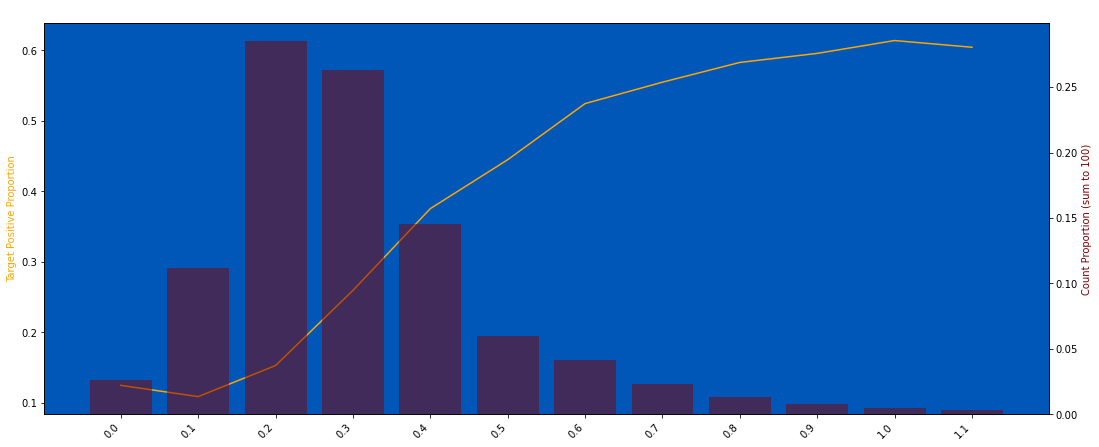

In [107]:
plot_target_check(train, "S_15", q=50, use_raw_bin=True, nunique_thr=500, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


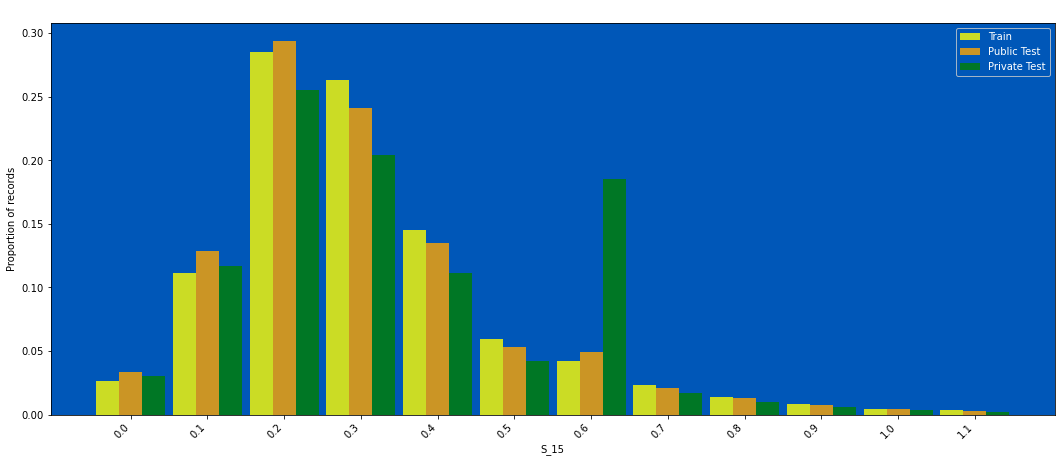

In [108]:
plot_train_test_distribution(df_list, "S_15", nunique_thr=500)

In [109]:
for df in df_list:
    df.loc[(df["S_15"].between(0.6, 0.61)) & (df["S_8"].isnull()), "S_15"] = np.nan

Bottom 1% and Top 1% are dropped from this chart


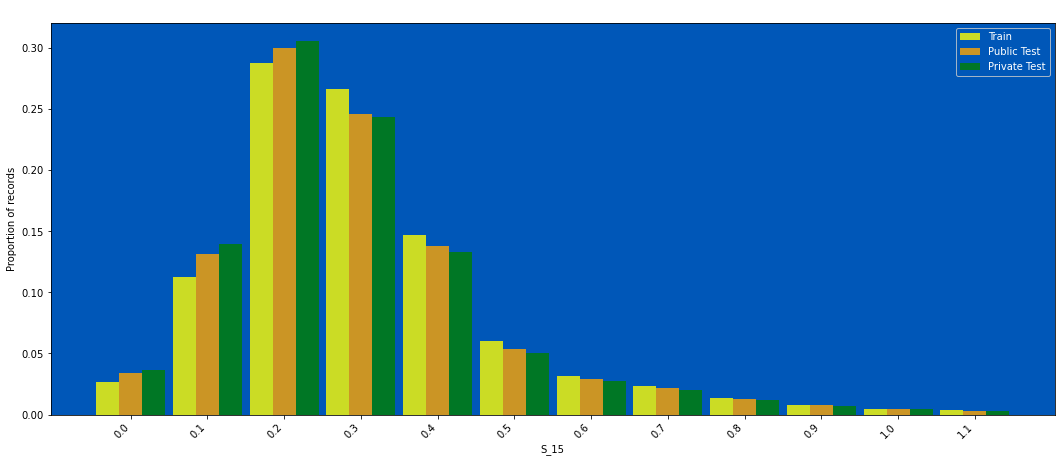

In [110]:
plot_train_test_distribution(df_list, "S_15", nunique_thr=500)

### S_16

0 null count, 0.000 null proportion
nan of the targets have label = 1


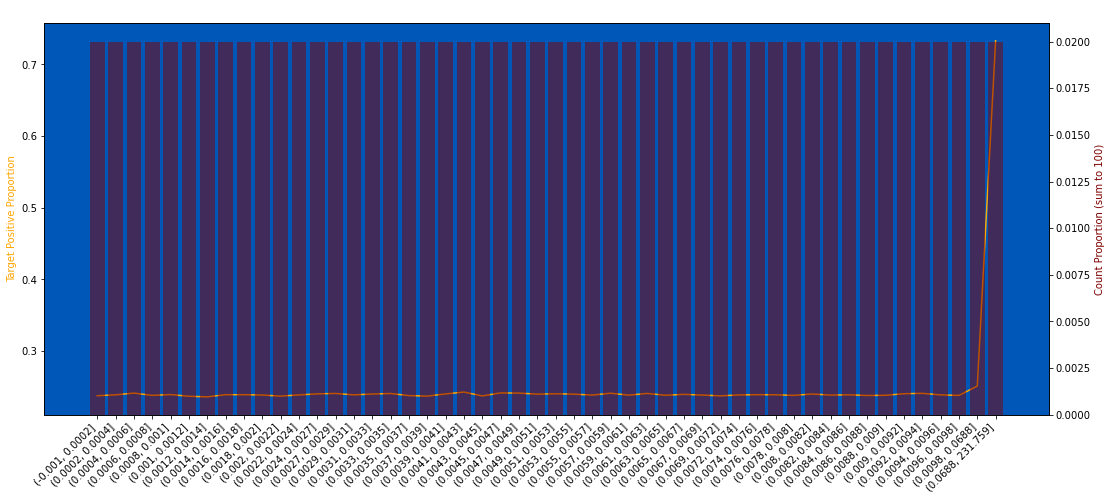

In [111]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True)

In [112]:
%%time
df_list = round_dfs(df_list, col="S_16", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 230 ms, sys: 1.07 s, total: 1.3 s
Wall time: 2.19 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


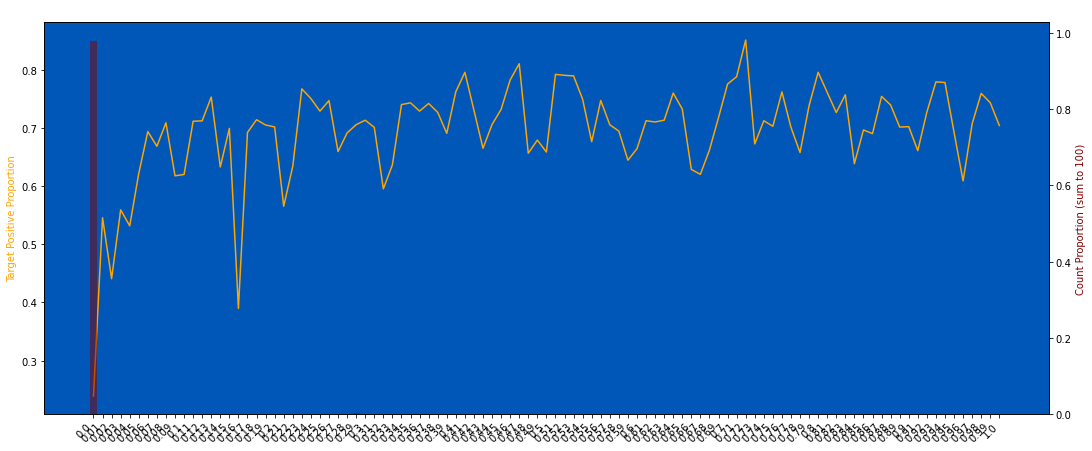

In [113]:
plot_target_check(train, "S_16", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


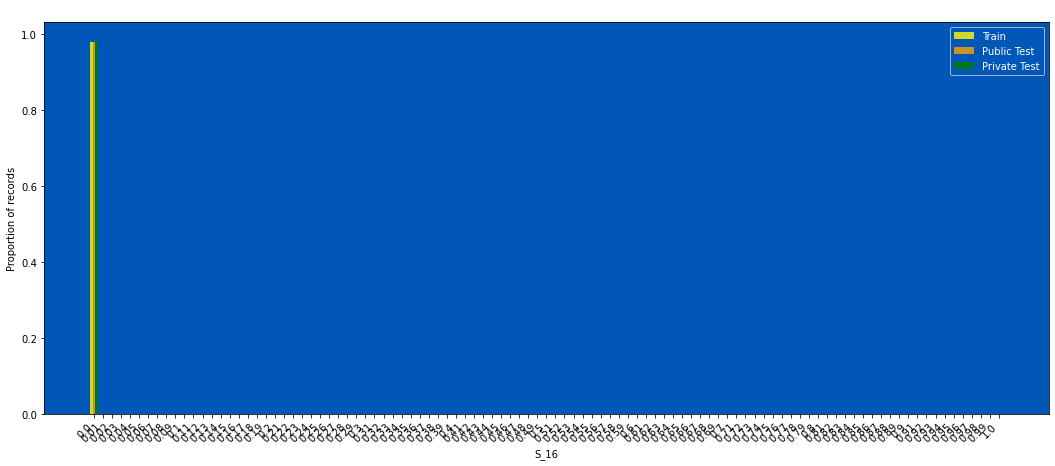

In [114]:
plot_train_test_distribution(df_list, "S_16", nunique_thr=5000)

**ToDo:**
- Replace some zeros as NaN

### S_17

0 null count, 0.000 null proportion
nan of the targets have label = 1


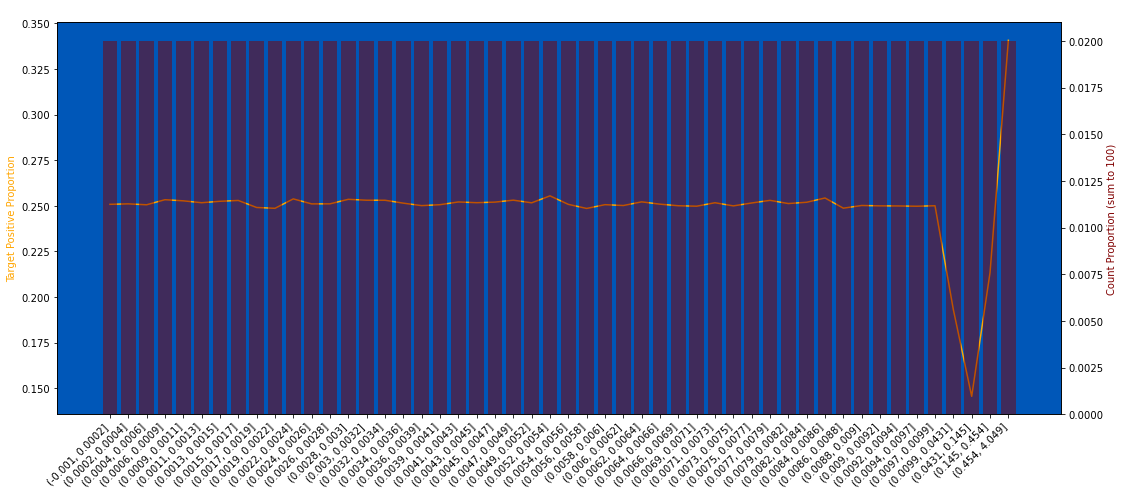

In [115]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True)

In [116]:
%%time
df_list = round_dfs(df_list, col="S_17", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 236 ms, sys: 1.05 s, total: 1.28 s
Wall time: 2.19 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


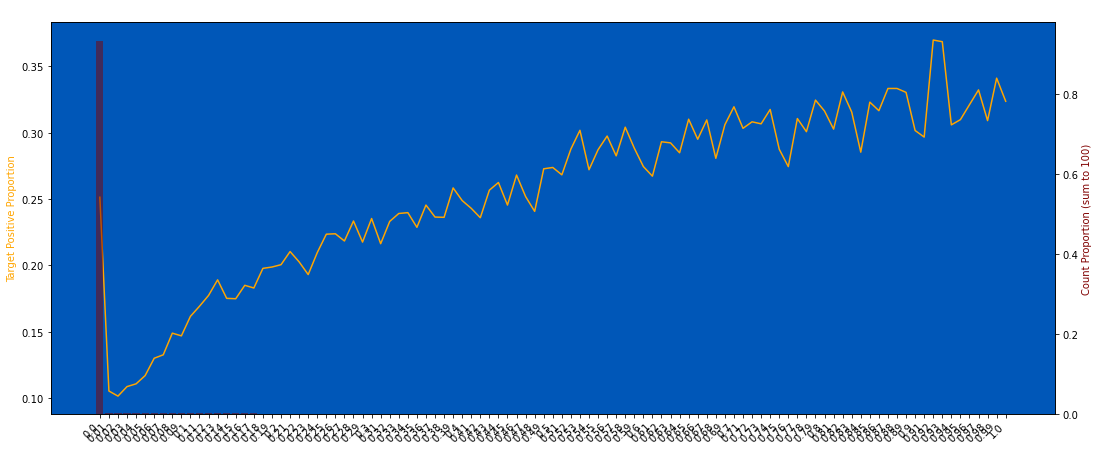

In [117]:
plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=5000, strfy_x=True)

In [118]:
df_list = fill_nans(df_list, col="S_17", method="point", tuple_of_values=(0, 0.01), add_new_col=False)

5165422 null count, 0.934 null proportion
0.2511 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


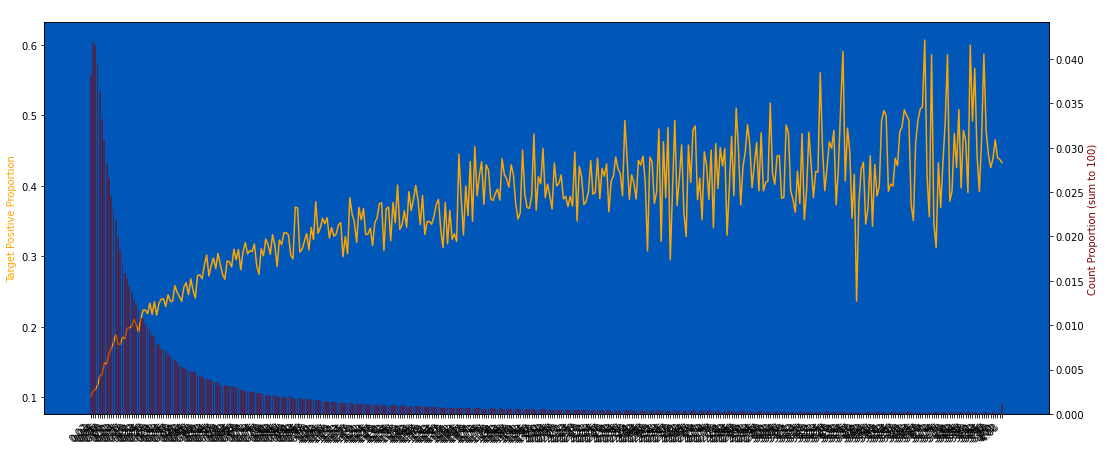

In [119]:
s17_summary = plot_target_check(train, "S_17", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True, return_df=True)

Bottom 1% and Top 1% are dropped from this chart


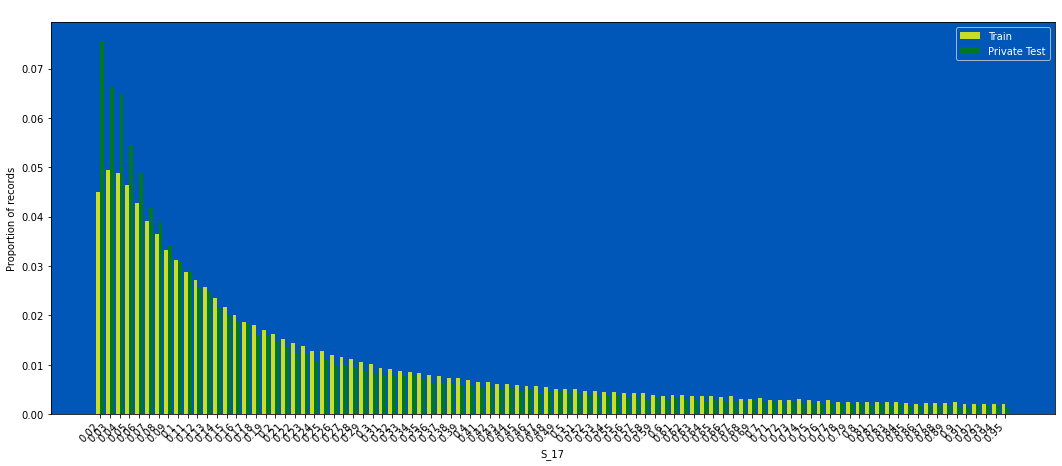

In [120]:
plot_train_test_distribution(
    [train.loc[train["S_17"] <= 1], 
    private_test.loc[private_test["S_17"] <= 1]],
    "S_17", 
    nunique_thr=15000
)

**Train Test Skew: Heavy**

### S_18

0 null count, 0.000 null proportion
nan of the targets have label = 1


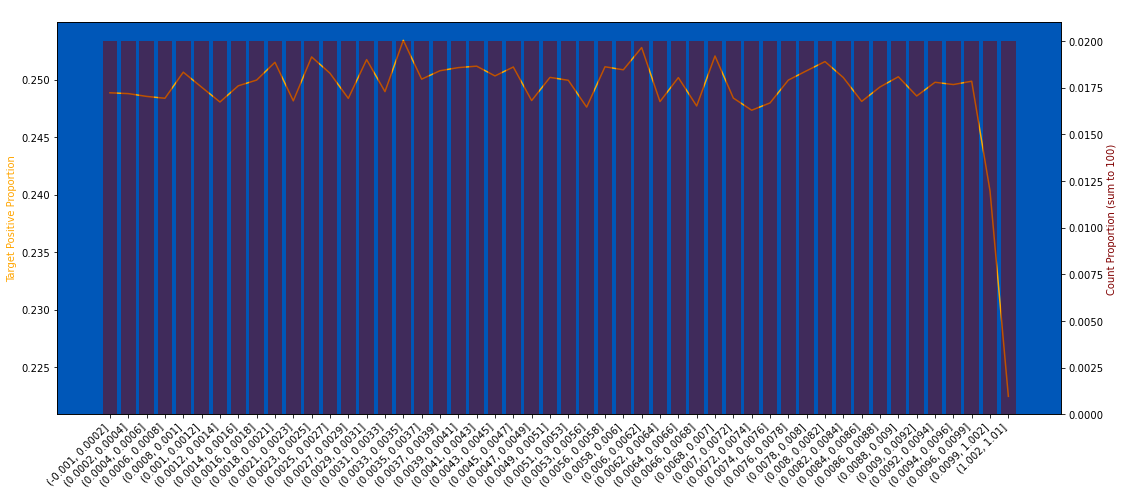

In [121]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True)

In [122]:
%%time
df_list = round_dfs(df_list, col="S_18", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 239 ms, sys: 988 ms, total: 1.23 s
Wall time: 2.16 s


0 null count, 0.000 null proportion
nan of the targets have label = 1


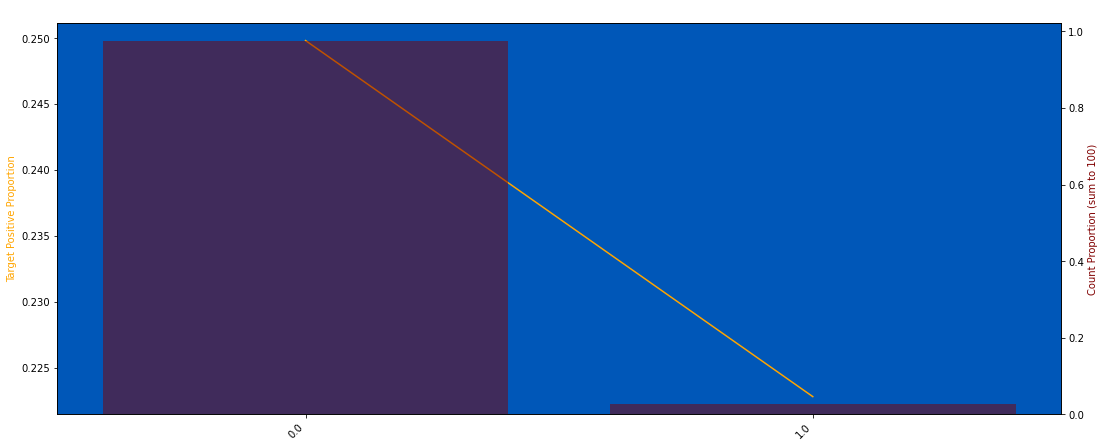

In [123]:
plot_target_check(train, "S_18", q=50, use_raw_bin=True, nunique_thr=5, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


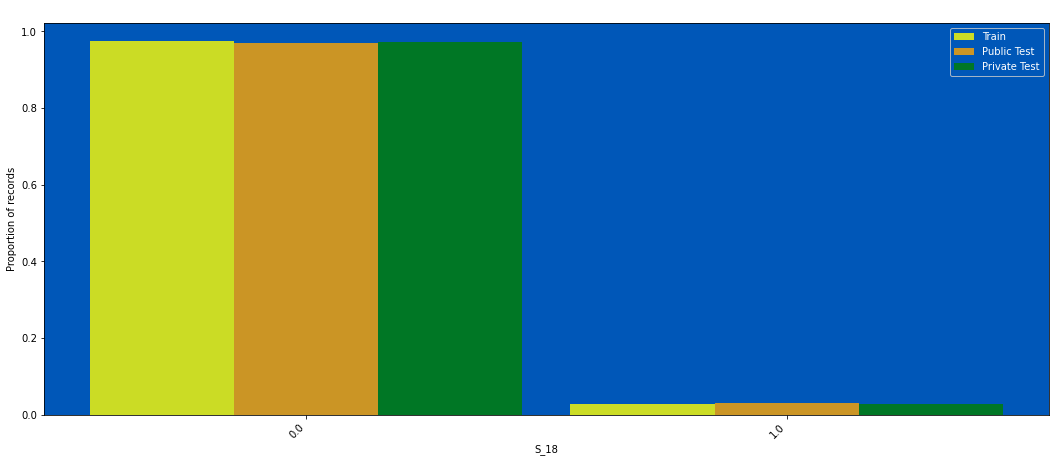

In [124]:
plot_train_test_distribution(df_list, "S_18", nunique_thr=150)

### S_19

0 null count, 0.000 null proportion
nan of the targets have label = 1


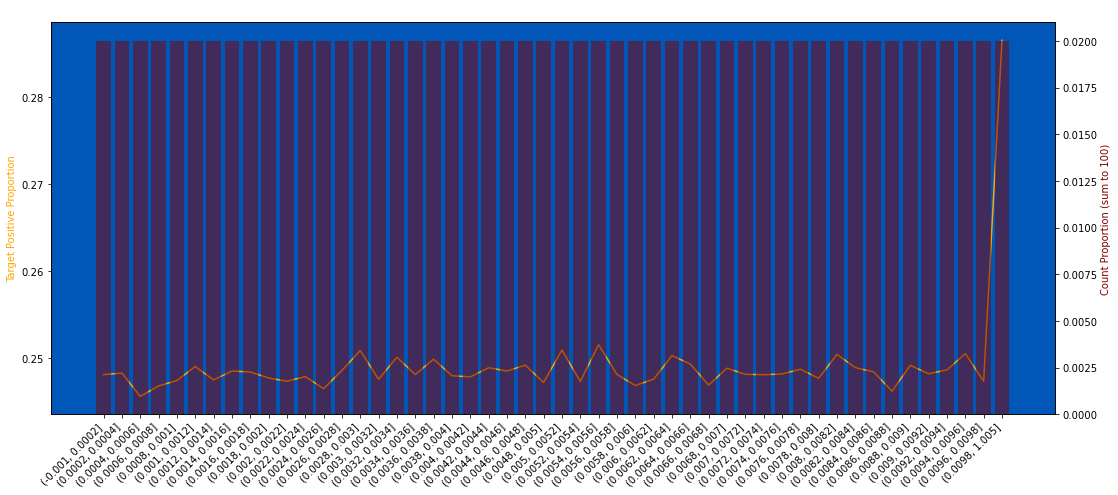

In [125]:
plot_target_check(train, "S_19", q=50, use_raw_bin=True)

In [126]:
%%time
df_list = round_dfs(df_list, col="S_19", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 266 ms, sys: 1.05 s, total: 1.32 s
Wall time: 2.23 s


In [127]:
for df in df_list:
    print(df["S_19"].mean())

2.7790176573923133e-05
2.6741993006693942e-05
2.6708393770487004e-05


In [128]:
%%time
for df in df_list:
    df = df.drop(columns=["S_19"], errors="ignore")

CPU times: user 721 ms, sys: 1.18 s, total: 1.9 s
Wall time: 2.08 s


### S_20

0 null count, 0.000 null proportion
nan of the targets have label = 1


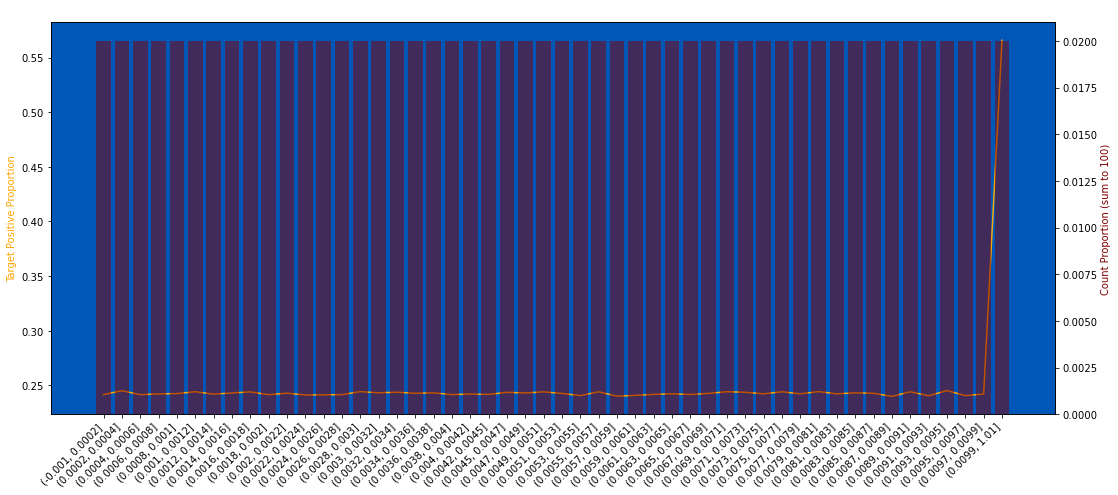

In [129]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=200)

In [130]:
%%time
df_list = round_dfs(df_list, col="S_20", decimals=1, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 234 ms, sys: 1.18 s, total: 1.41 s
Wall time: 2.55 s


0 null count, 0.000 null proportion
nan of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


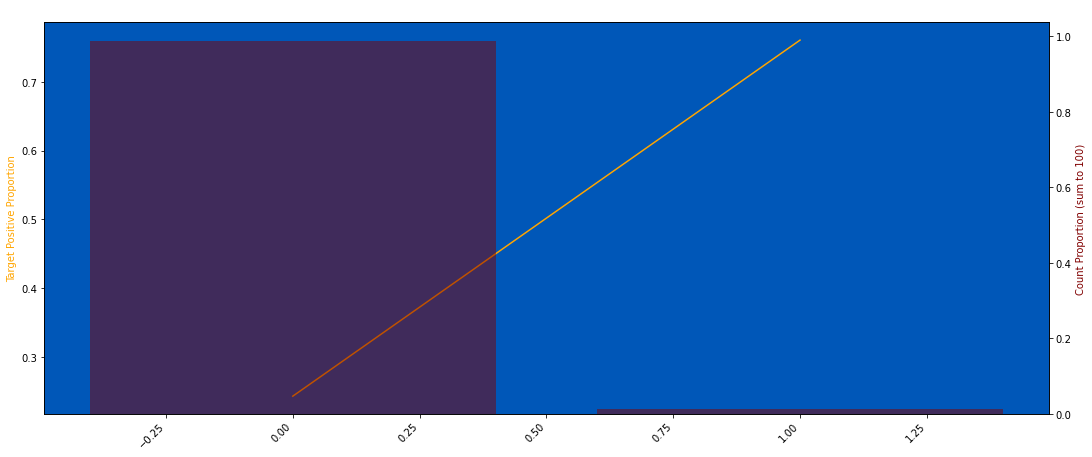

In [131]:
plot_target_check(train, "S_20", q=50, use_raw_bin=True, nunique_thr=2000)

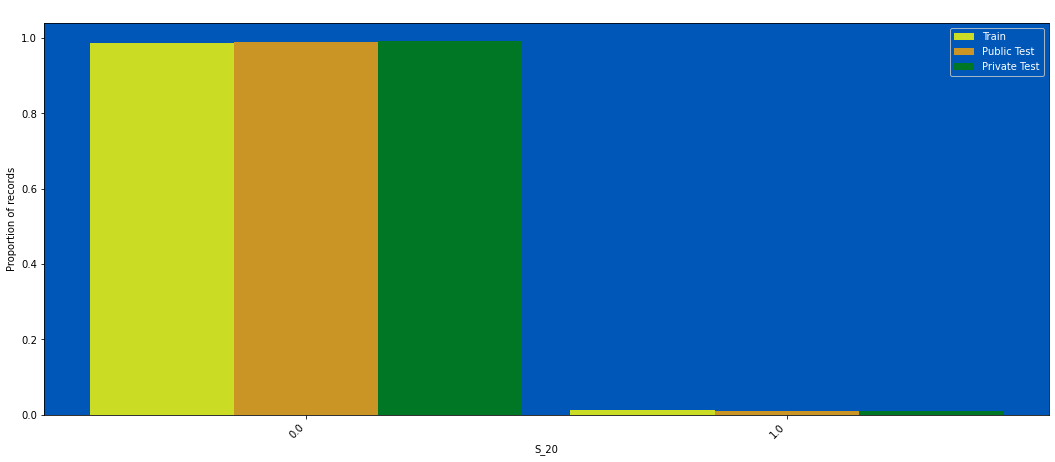

In [132]:
plot_train_test_distribution(df_list, "S_20", nunique_thr=50)

### S_22

19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1


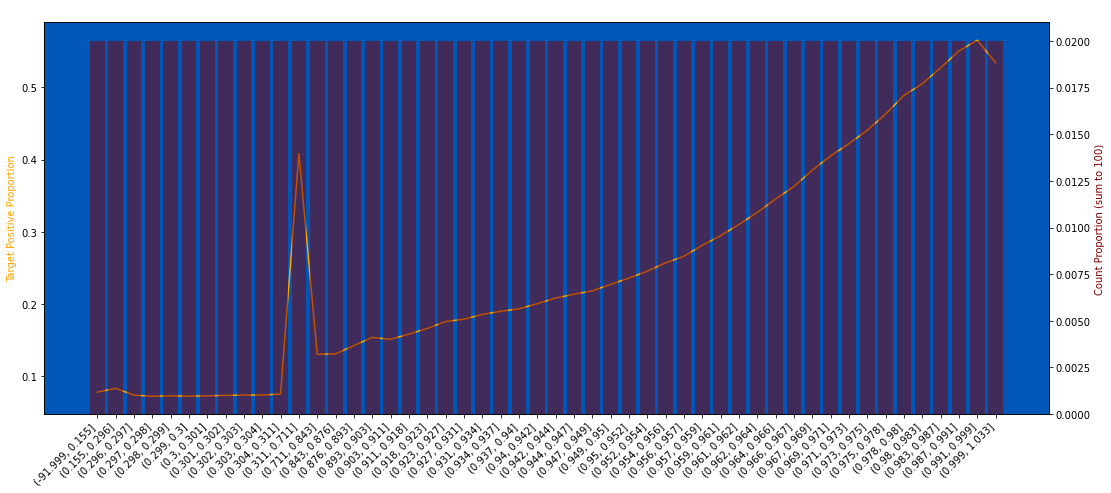

In [133]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True)

In [134]:
%%time
df_list = round_dfs(df_list, col="S_22", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 234 ms, sys: 1.03 s, total: 1.26 s
Wall time: 2.18 s


19024 null count, 0.003 null proportion
0.1320 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


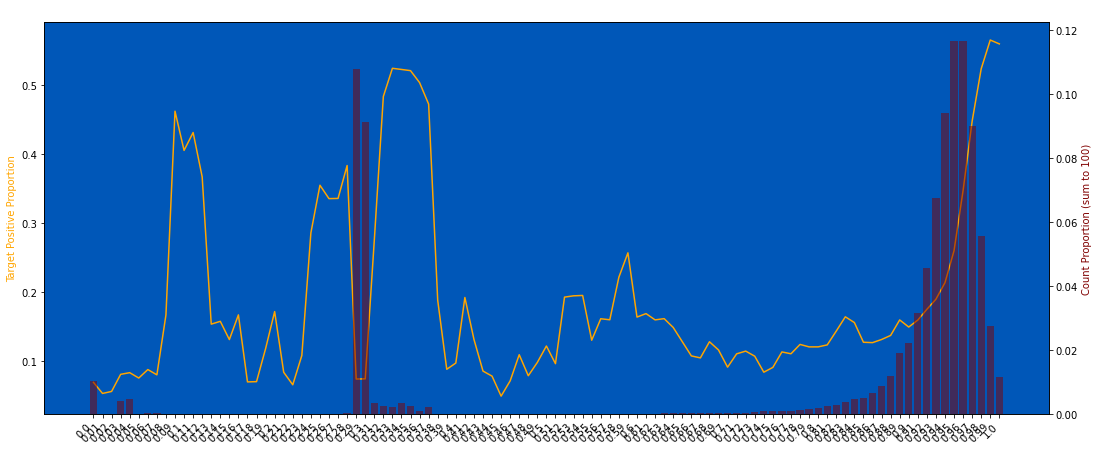

In [135]:
plot_target_check(train, "S_22", q=50, use_raw_bin=True, nunique_thr=777, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


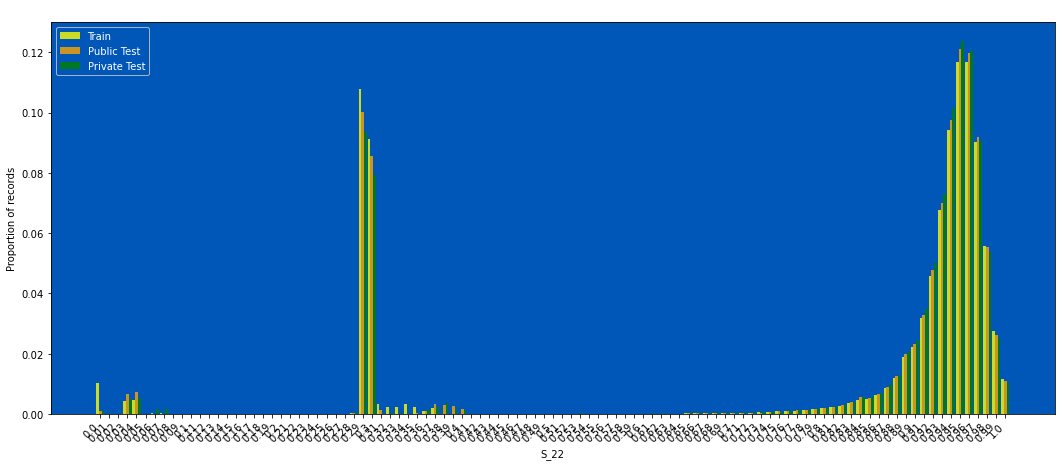

In [136]:
plot_train_test_distribution(df_list, "S_22", nunique_thr=777)

**Comments:**
- **Train Test Skew: Moderate**
- Relationship is ambigious

### S_23

445 null count, 0.000 null proportion
0.5236 of the targets have label = 1


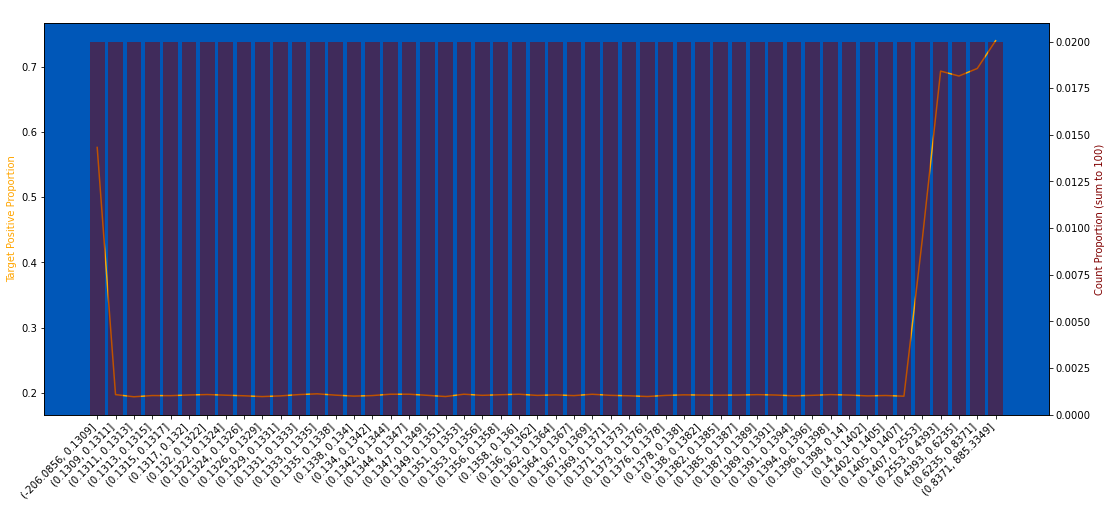

In [137]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True)

In [138]:
%%time
df_list = round_dfs(df_list, col="S_23", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 238 ms, sys: 1e+03 ms, total: 1.24 s
Wall time: 2.17 s


445 null count, 0.000 null proportion
0.5236 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


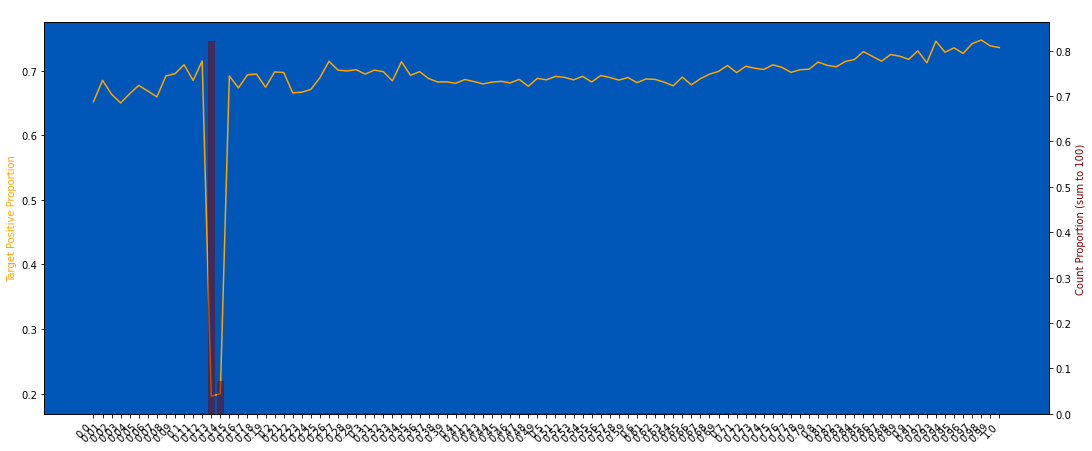

In [139]:
plot_target_check(train, "S_23", q=50, use_raw_bin=True, strfy_x=True, nunique_thr=1600)

**ToDo:**
- Identify the subset of 0.13 & 0.14 to be replace by NaN

Bottom 1% and Top 1% are dropped from this chart


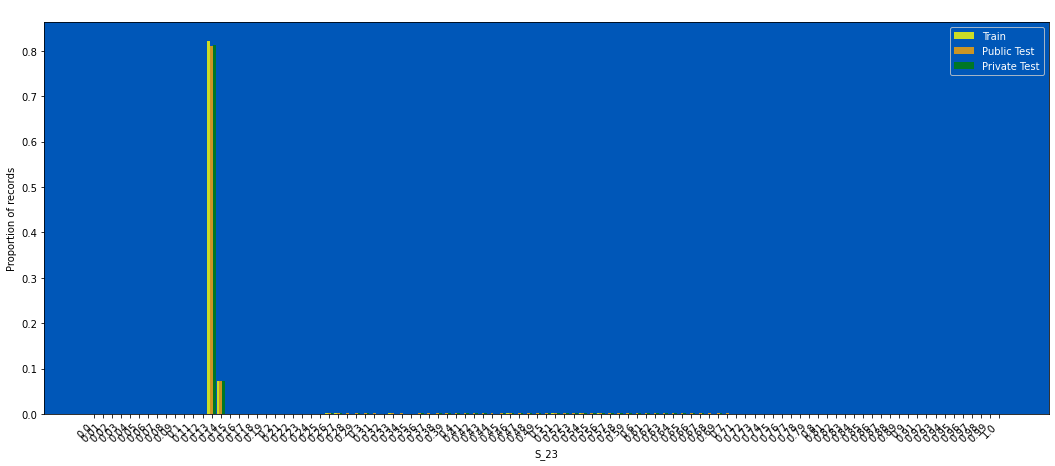

In [140]:
plot_train_test_distribution(df_list, "S_23", nunique_thr=1600)

### S_24

18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1


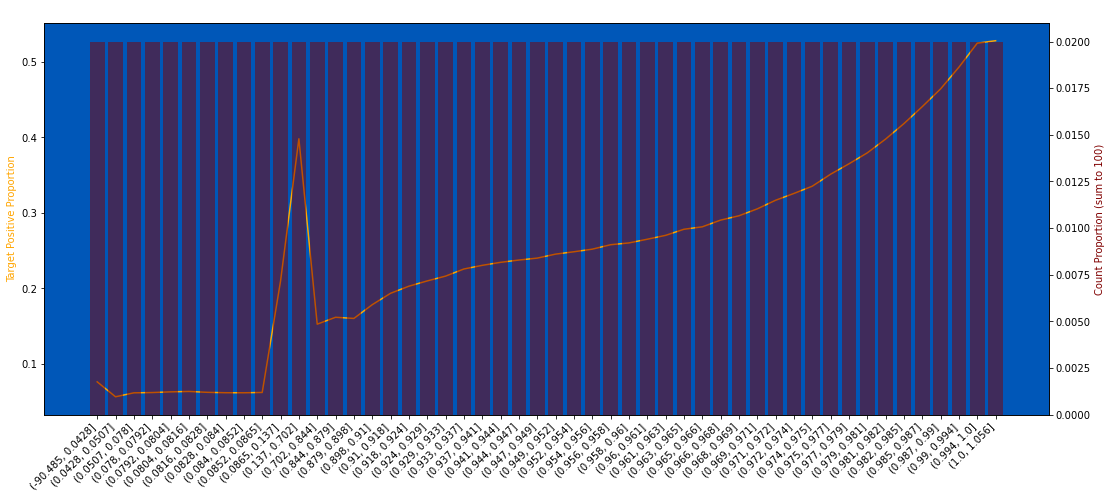

In [141]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True)

In [142]:
%%time
df_list = round_dfs(df_list, col="S_24", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 232 ms, sys: 953 ms, total: 1.19 s
Wall time: 2.13 s


18593 null count, 0.003 null proportion
0.1317 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


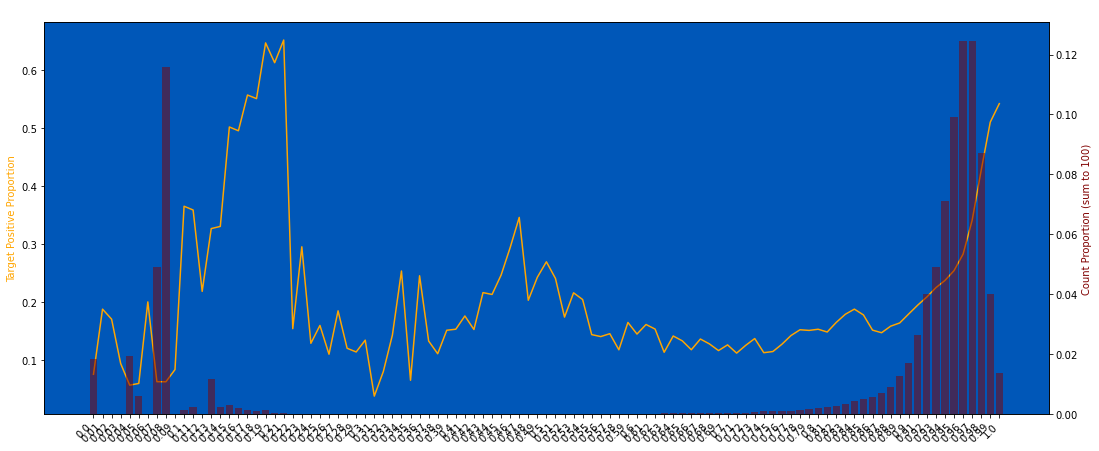

In [143]:
plot_target_check(train, "S_24", q=50, use_raw_bin=True, nunique_thr=650, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


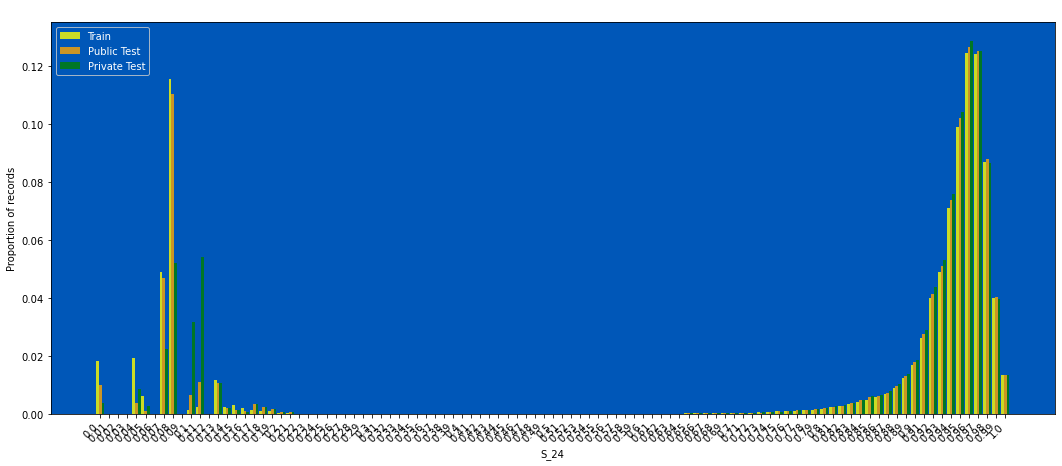

In [144]:
plot_train_test_distribution(df_list, "S_24", nunique_thr=650)

**Train Test Skew: Heavy**

### S_25

12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1


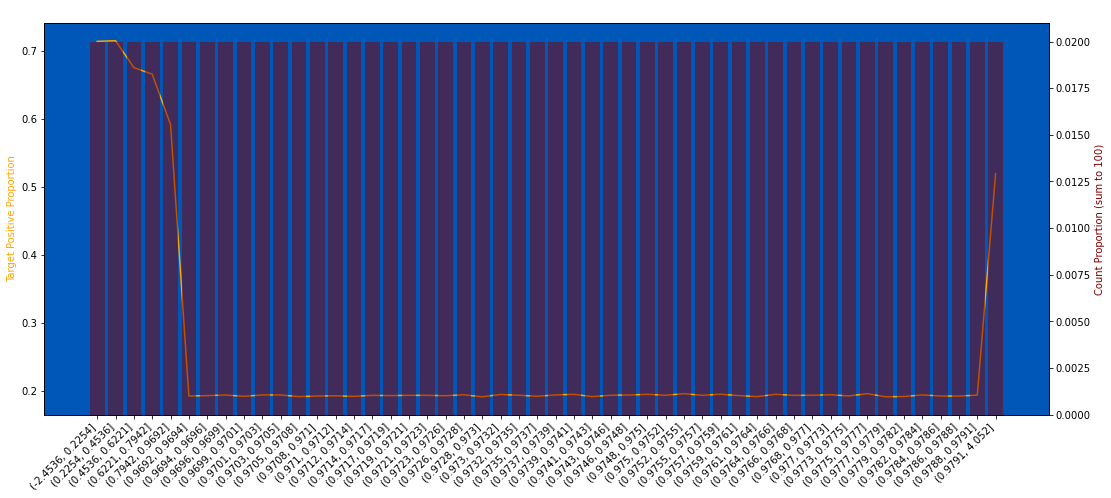

In [145]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True)

In [146]:
%%time
df_list = round_dfs(df_list, col="S_25", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 236 ms, sys: 1.01 s, total: 1.25 s
Wall time: 2.17 s


12847 null count, 0.002 null proportion
0.6575 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


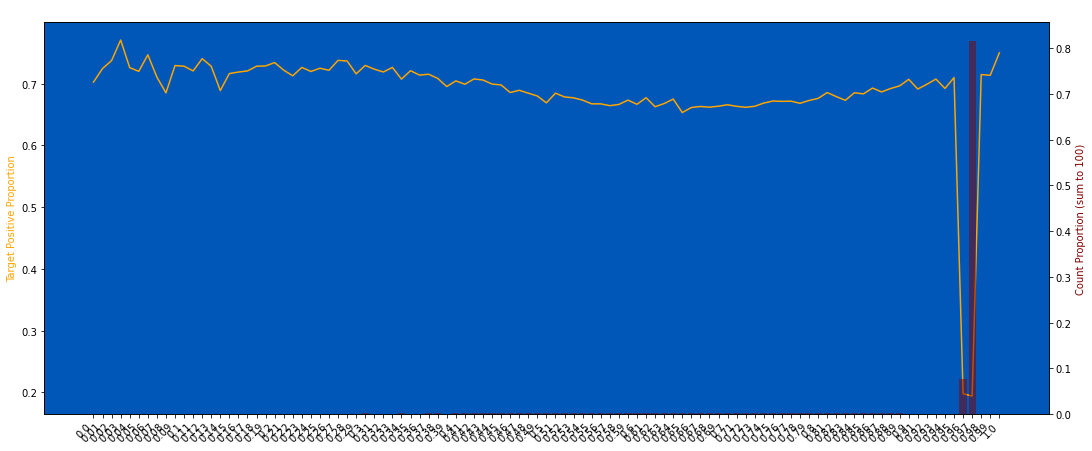

In [147]:
plot_target_check(train, "S_25", q=50, use_raw_bin=True, nunique_thr=1000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


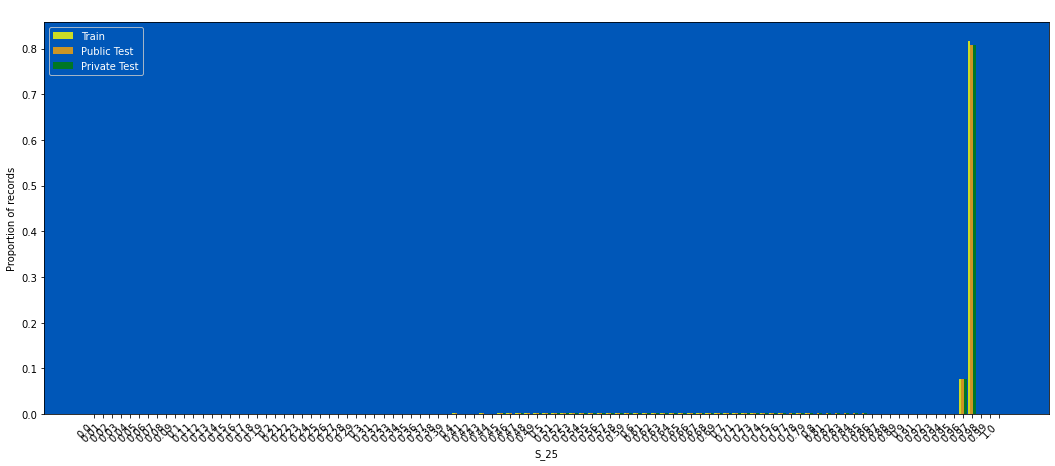

In [148]:
plot_train_test_distribution(df_list, "S_25", nunique_thr=1500)

**Train Test Skew: Moderate**

**ToDo:**
- Identify the subset of 0.97 & 0.98 to be replace by NaN

### S_26

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1


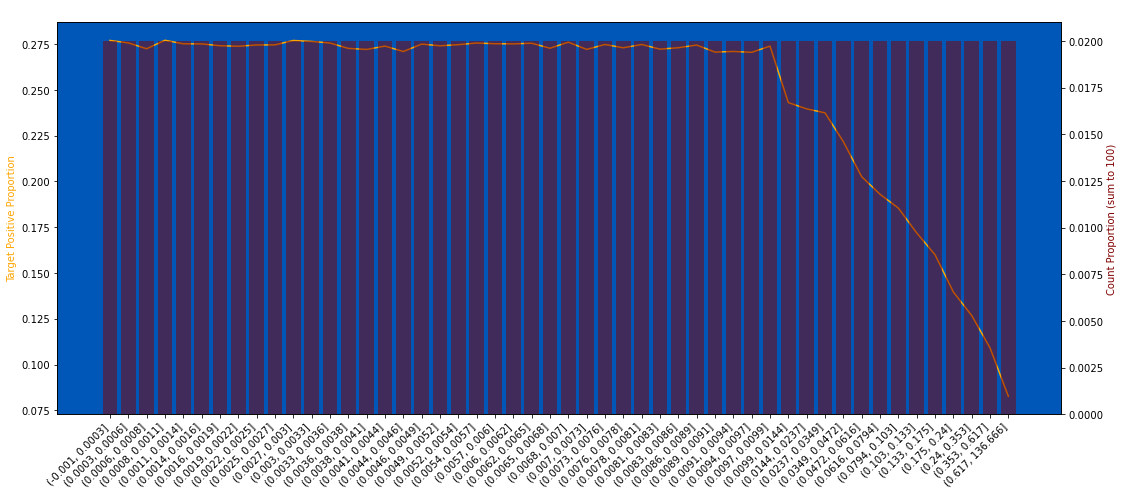

In [149]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True)

In [150]:
%%time
df_list = round_dfs(df_list, col="S_26", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 233 ms, sys: 1.05 s, total: 1.28 s
Wall time: 2.22 s


634 null count, 0.000 null proportion
0.1325 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


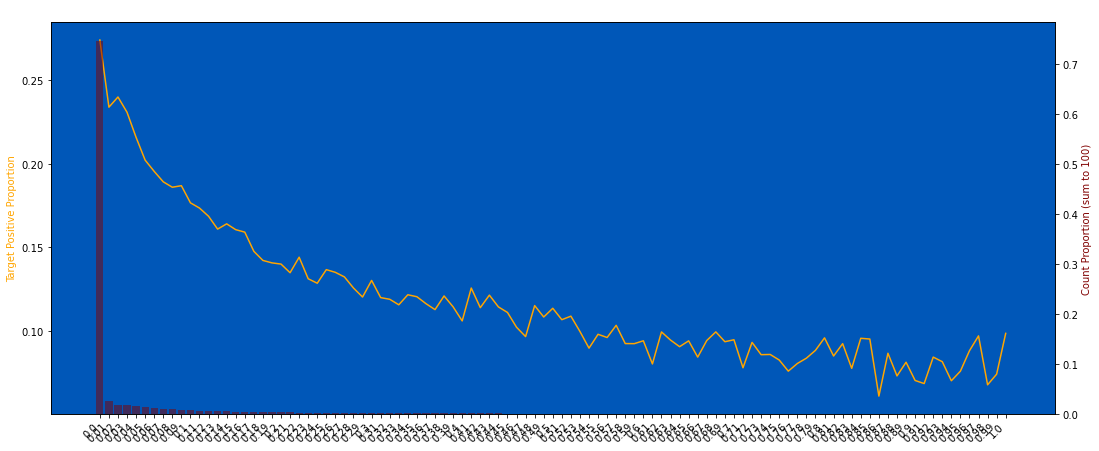

In [151]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

In [152]:
for df in df_list:
    df["S_26"] = df["S_26"].parallel_apply(lambda x: manual_stack(x, start=0.01, stack_interval=0.05, denom=100))

634 null count, 0.000 null proportion
0.1325 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


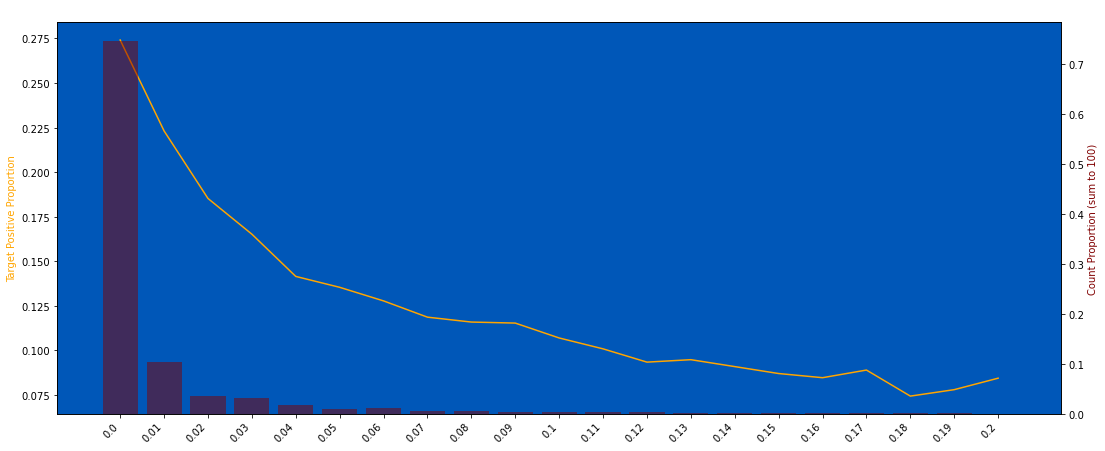

In [153]:
plot_target_check(train, "S_26", q=50, use_raw_bin=True, nunique_thr=2000, strfy_x=True)

Bottom 1% and Top 1% are dropped from this chart


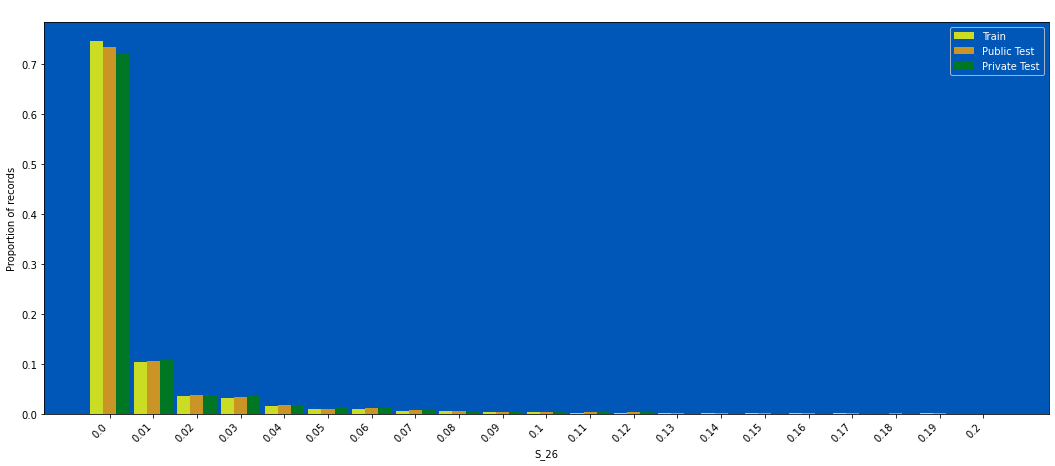

In [154]:
plot_train_test_distribution(df_list, "S_26", nunique_thr=2000)

### S_27

1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1


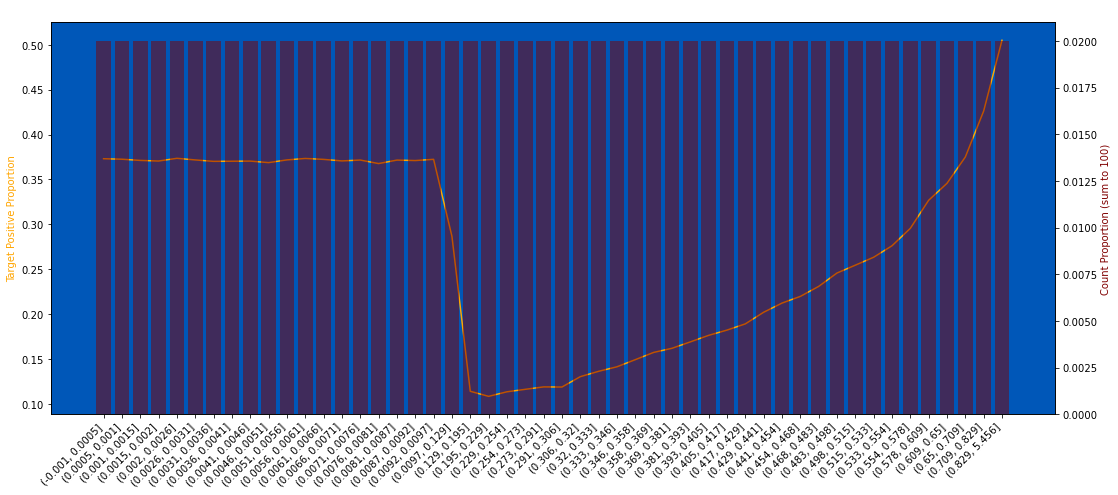

In [155]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True)

In [156]:
%%time
df_list = round_dfs(df_list, col="S_27", decimals=2, add_new_col=False)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
CPU times: user 258 ms, sys: 1.07 s, total: 1.33 s
Wall time: 2.31 s


1400935 null count, 0.253 null proportion
0.1697 of the targets have label = 1
Bottom 1% and Top 1% are dropped from this chart


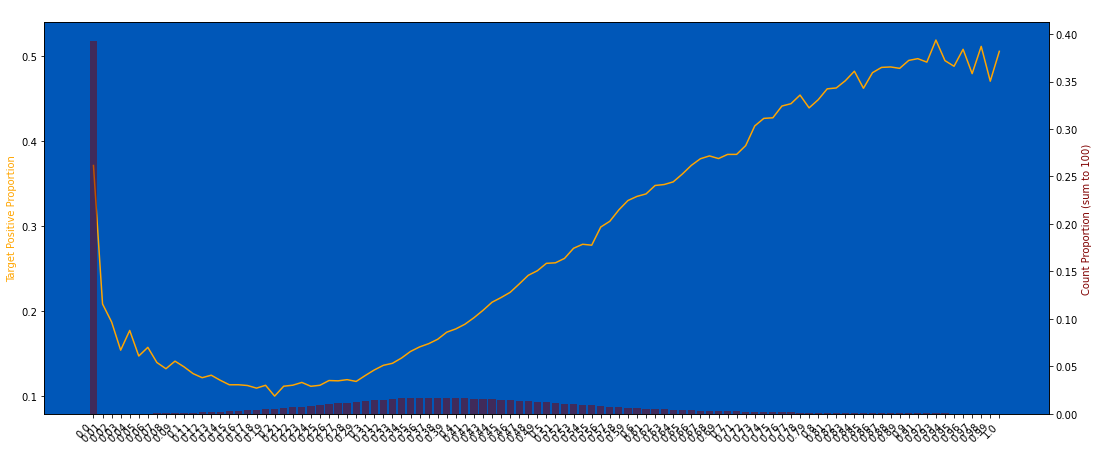

In [157]:
plot_target_check(train, "S_27", q=50, use_raw_bin=True, nunique_thr=1500, strfy_x=True)

**ToDo:**
- Impute, then set 0 & 0.01 as NaN??

Bottom 1% and Top 1% are dropped from this chart


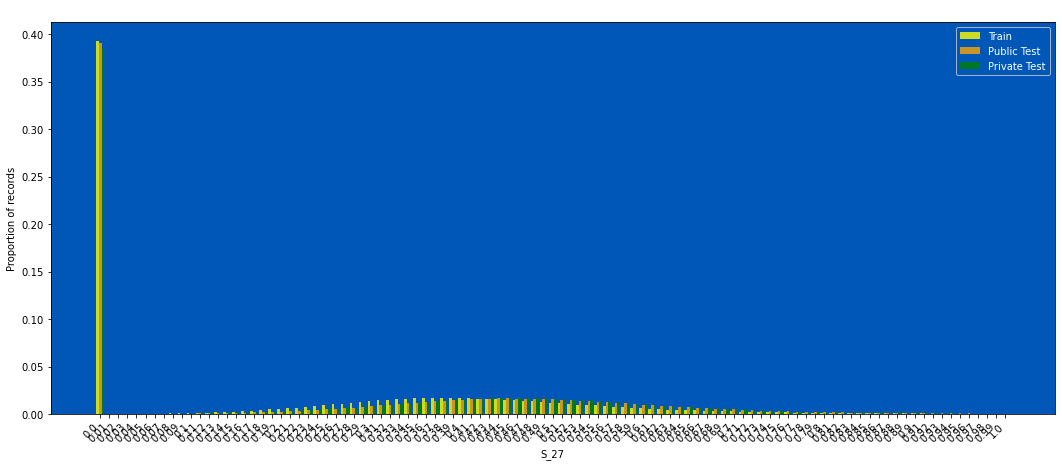

In [158]:
plot_train_test_distribution(df_list, "S_27", nunique_thr=1500)

**Train Test Skew: Heavy**

### Column checking

In [159]:
from tqdm import tqdm

In [160]:
no_use_features = ["temp"] + df_list[0].columns[df_list[0].columns.str.endswith("_")].tolist()
no_use_features

['temp', 'P_4_', 'S_11_', 'S_15_']

In [161]:
%%time
for df in df_list:
    df.drop(columns=no_use_features, errors="ignore", inplace=True)

CPU times: user 530 ms, sys: 733 ms, total: 1.26 s
Wall time: 1.26 s


In [162]:
all_columns = get_cols(df_list[0], ["P_", "S_"])

In [163]:
for d in tqdm(all_columns):
    for df in df_list:
        df[d] = df[d].fillna(-127)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:20<00:00,  1.25it/s]


In [164]:
d_col_nunique = df_list[0][all_columns].nunique()
less_unique_d_cols = d_col_nunique[d_col_nunique < 100].index.tolist()
for d in less_unique_d_cols:
    print(d, ":", df_list[0][d].dtype, "\n", sorted(df_list[0][d].unique().tolist()), "\n")

S_6 : int32 
 [0, 1] 

S_8 : float64 
 [-127.0, 0.1, 0.11, 0.12, 0.16, 0.17, 0.24, 0.25, 0.31, 0.32, 0.33, 0.35, 0.36, 0.4, 0.41, 0.45, 0.46, 0.47, 0.48, 0.49, 0.59, 0.6, 0.61, 0.66, 0.67, 0.7, 0.71, 0.74, 0.75, 0.76, 0.85, 0.86, 0.91, 0.92, 0.93, 0.94, 1.0, 1.01, 1.02, 1.1, 1.11, 1.14, 1.15, 1.16, 1.22, 1.23] 

S_9 : float64 
 [-127.0, 0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7] 

S_11 : int64 
 [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55,

In [165]:
cols = ["S_6", "S_11", "S_18", "S_20"]

In [166]:
for col in tqdm(cols):
    for df in df_list:
        df[col] = integerize(df[col])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.27it/s]


In [167]:
%%time
test = pd.concat(df_list[1:], axis=0)
test = test.sort_values(by=["customer_ID", "S_2"]).reset_index(drop=True)

CPU times: user 4.08 s, sys: 2.98 s, total: 7.06 s
Wall time: 9.09 s


In [168]:
train = df_list[0]

In [169]:
train.shape, test.shape

((5531451, 27), (11363762, 26))

In [174]:
%%time
train.to_parquet(f"{INTERIM_TRAIN_PARQUET_PATH}/spend_payment.parquet")
test.to_parquet(f"{INTERIM_TEST_PARQUET_PATH}/spend_payment.parquet")

CPU times: user 7.49 s, sys: 541 ms, total: 8.03 s
Wall time: 7.31 s


In [175]:
END = time.time()

In [176]:
print(f"{END - START:.2f} seconds elapsed")

295.15 seconds elapsed


In [177]:
train.tail()

,customer_ID,S_2,P_2,S_3,P_3,S_5,S_6,S_7,S_8,S_9,...,S_18,S_19,S_20,S_22,S_23,S_24,S_25,S_26,S_27,target
5531446,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-11-05,0.9700,0.0900,0.6800,0.0300,0,0.0500,0.7000,0.0000,...,0,0.0000,0,0.9700,0.1300,0.9700,0.9700,0.0000,0.2500,0
5531447,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2017-12-23,0.9800,0.0700,0.7000,0.0000,0,0.0400,0.7000,0.0000,...,0,0.0000,0,0.8700,0.1300,0.9000,0.9700,0.0000,0.2500,0
5531448,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-01-06,0.9800,0.1000,0.7100,0.0000,0,0.0500,0.3200,0.0000,...,0,0.0000,0,0.8600,0.1300,0.8800,0.9700,0.0000,0.3400,0
5531449,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-02-06,0.9600,0.1000,0.6400,0.0000,0,0.0500,0.3200,0.0000,...,0,0.0000,0,0.8700,0.1300,0.8800,0.9700,0.0000,0.2000,0
5531450,fffff1d38b785cef84adeace64f8f83db3a0c31e8d92ea...,2018-03-14,0.9800,0.1100,0.6100,0.0000,0,0.0600,-127.0000,0.0000,...,0,0.0000,0,0.2900,0.1300,0.0800,0.9700,0.0000,0.0000,0
